# Importing Libraries and Dataset

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from ydata_profiling import ProfileReport
import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose, STL, MSTL
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from plotly.subplots import make_subplots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from collections import defaultdict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
import random
import xgboost as xgb
from prophet import Prophet
# from pmdarima.arima import decompose
# from pmdarima.utils import decomposed_plot

In [2]:
df = pd.read_csv('Data/walmart.csv')

# Preliminary Data Cleaning

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [5]:
df.head(3)

Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106

In [6]:
df.tail(3)

Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
6432     45  12-10-2012     734464.36             0        54.47       4.000   
6433     45  19-10-2012     718125.53             0        56.47       3.969   
6434     45  26-10-2012     760281.43             0        58.85       3.882   

             CPI  Unemployment  
6432  192.327265         8.667  
6433  192.330854         8.667  
6434  192.308899         8.667

In [3]:
def cleaning(df_copy: pd.DataFrame) -> pd.DataFrame:
    df = df_copy.copy(deep=True)
    df['Date'] = pd.to_datetime(df['Date'], format=r"%d-%m-%Y")
    df['Store'] = df['Store'].astype(pd.StringDtype()).astype('category')
    df['Holiday_Flag'] = df['Holiday_Flag'].astype(pd.BooleanDtype())
    df = df.rename(columns={col: col.lower() for col in df.columns})
    return df

df = cleaning(df)

# Analysis

## Final/Major Observations

1. There are 45 unique stores and we have data on weekly sales for 143 weeks for each store starting from 5th Feb 2010 to 26 Oct 2012
2. Except holiday_flag, all other variables like weekly_sales, temperature, fuel_price, cpi, unemployment are unique to each store and date. holiday_flag is common for all stores.
3. There are no missing values in the dataset.
4. Holiday_flag is highly imbalanced with only 10% of the data being holiday weeks.
5. From visually inspecting the total sales for each week overlapped with holiday weeks, we can clearly see a seasonal trend. The holiday_flags are mostly set for these occassions:
    - Valentines day or superbowl (2nd week of Feb)
    - Labour day/ back to school (1st or 2nd week of Sept)
    - Thanksgiving and Black Friday (3rd and/or 4th week of Nov around Nov 24th)
    - Christmas and New Years (3rd and/or 4th week of Dec around Dec 24th)
    - Also, very few stores also see boost in Sales for Independence day (1st week of July around July 4th)
6. From visual inspection of the Times series decomposition plot using STL, what I noticed is it cannot properly decompose the sales into a "nice" continuous seasonal component. The seasonal effect is directly due to the recurring holiday sales boots, but they are randomly distributed over the year and repeat yearly. It's not like every month there's a holiday at a fixed interval. They are inconsistently distributed. So, technically the season is 52 weeks long. But, the seasonal effect is not efficiently captured by the STL decomposition.
6. From visual inspection, most sales get boosted by Balck Friday and New Years. Valentines week does see some boost in sales but not as significant as others. Labour day does not seem to have a significant impact on sales.
7. The series looks additive for all stores from visual inspection of plots.
8. Unemployment is highly negatively correlated with cpi for almost all stores.
9. Unemployment is also substantially negatively correlated with fuel_price for almost all stores. Not as strongly correlated as with cpi, but still significant.
10. Store 36 is definitely an odd one out. It's weekly sales show a clear downward trend with no seasonal effects.
11. Unemployment
    - When looking at coorelation coefficients for weekly_sales vs unemployment; Looking at it, the trend component of weekly sales is definitely more correlated with unemployment than regular weekly_sales. But, there's high contrast in how it's correlated. Sometimes it's strongly positive, sometimes it's strongly negative. Few times it's close to zero. So, I'm not sure if it's a good indicator of whether there's a relationship between weekly_sales and unemployment.
12. Consumer Price Index:
    - When looking at weekly_sales and cpi directly, the correlations is insignificant. But, when considering only the trend component with respect to CPI, there seems to be a significant correlation.
    - Most of the correlations are strongly positive. Very few are strongly negative. And even fewer are weakly positive or negative.
    - If for all stores the correlations were in same direction with significant magnitude, then it would hold some meaning. But, it doesn't.
13. Temperature:
    - There is no correlation between weekly_sales and temperature
14. CPI and Fuel price are strongly positively correlated with each other for ALL stores with average Pearson correlation coefficient of 0.814. This is intuitive because fuel pice is generally considered when calculating CPI.
15. Unemployment and CPI are negatively correlated for most stores. For 75% of then stores, the correlation is greater in magnitude than 0.73 and for 85% of the stores it's greater in magnitude than 0.51. But, for the rest of the stores, the correlation gets closer to zero. And for store 24, the correlation is strongly positive with the coefficient being 0.86
16. Fuel Price and Unemployment are negatively correlated for most stores. This correlation isn't as strong as Unemployment and CPI. For 75% of then stores, the correlation is greater in magnitude than 0.53. But, for the rest of the stores, the correlation gets closer to zero. And for store 24, the correlation is strongly positive with the coefficient being 0.6
17. PCA on CPI, Unemployment and Fuel Price:
    - The 3 features cpi, unemployment and fuel_price are reduced to 2 principal components which on average (across all stores) explains 97% variance across the 3 features.
    - When I tried reducing the features to just 1 principal component, I got worse results where on average (across all stores) the variance explained was only 83%

In [11]:
df.columns.tolist()

['store',
 'date',
 'weekly_sales',
 'holiday_flag',
 'temperature',
 'fuel_price',
 'cpi',
 'unemployment']

## Checking if features vary only with date or store too

In [20]:
df.set_index(['store', 'date'])['cpi'].unstack().T.sample(3)

store                1          10          11          12          13  \
date                                                                     
2010-04-09  210.622857  126.601903  213.912059  126.601903  126.601903   
2012-02-03  220.172015  130.349677  223.659114  130.349677  130.349677   
2010-03-12  211.380643  126.604286  214.702765  126.604286  126.604286   

store               14          15          16          17          18  ...  \
date                                                                    ...   
2010-04-09  181.759638  131.940807  189.690101  126.601903  131.940807  ...   
2012-02-03  189.612228  137.063258  196.872892  130.349677  137.063258  ...   
2010-03-12  182.162844  131.784000  189.737208  126.604286  131.784000  ...   

store               41          42          43          44          45  \
date                                                                     
2010-04-09  189.690101  126.601903  202.659465  126.601903  181.759638   
2012-02-03  196.872892  130.349677  211.676200  130.349677  189.612228   
2010-03-12  189.737208  126.604286  203.343658  126.604286  182.162844   

store                5           6           7           8           9  
date                                                                    
2010-04-09  211.173883  212.130824  189.690101  213.958079  214.139914  
2012-02-03  220.756194  221.770709  196.872892  223.707902  223.900677  
2010-03-12  211.937184  212.903702  189.737208  214.749245  214.932899  

[3 rows x 45 columns]

In [21]:
df.set_index(['store', 'date'])['temperature'].unstack().T.sample(3)

store           1     10     11     12     13     14     15     16     17  \
date                                                                        
2011-08-19  89.94  87.40  89.51  91.74  76.68  72.98  70.41  68.83  67.59   
2011-11-18  62.25  58.97  66.17  54.20  40.65  51.34  46.53  31.73  32.93   
2012-01-06  49.01  59.85  54.44  50.43  33.80  35.88  30.24  26.49  27.64   

store          18  ...     41     42     43     44     45      5      6  \
date               ...                                                    
2011-08-19  69.24  ...  70.55  87.40  82.08  76.68  72.98  89.35  89.26   
2011-11-18  47.88  ...  36.64  58.97  57.75  40.65  51.34  64.33  63.89   
2012-01-06  31.27  ...  37.21  59.85  47.59  33.80  35.88  50.21  50.82   

store           7      8      9  
date                             
2011-08-19  56.06  82.92  85.80  
2011-11-18  29.53  51.72  58.80  
2012-01-06  18.67  43.47  47.54  

[3 rows x 45 columns]

In [22]:
ndf = df.set_index(['store', 'date'])['holiday_flag'].unstack().T.astype(int)

In [23]:
for column in ndf.columns[1:]:
    if not (ndf[ndf.columns[0]] == ndf[column]).all():
        print(column)

### Conclusions/observations
Except holiday_flag, all other variables like weekly_sales, temperature, fuel_price, cpi, unemployment are unique to each store and date. holiday_flag is common for all stores.

## Univariate and Bivariate Analysis using Ydata Profiling

In [ ]:
for store in df['store'].unique():
    temp = df.loc[df['store'] == store].drop(columns=['store']).copy()
    report = ProfileReport(temp, title=f'Store {store}')
    report.to_file(f'Reports/store_{store}.html', silent=True)

## Miscellaneous Analysis

In [48]:
px.bar(
    df['date'].drop_duplicates().dt.year.value_counts().reset_index().sort_values('date').astype({'date':'str'}),
    x = 'date', y = 'count'
)

The data is incomplete for years 2010 and 2012. So, the yearly cycle needs to be offset while considering 2010 values as the starting point

In [54]:
px.line(
    df.pivot_table(index = 'date', columns = 'store', values = 'weekly_sales', observed=True).mean(axis=1).reset_index().rename(columns={0: 'sales'}),
    x='date',
    y='sales',
)

- April 6 (specifically 2012)
- August 6
- June 4 (specifically 2011, 2012)

### Checking sales with respect to date and holidays

In [173]:
tdf = df.pivot_table(index = 'date', columns = 'store', values = 'weekly_sales', observed=True)
store = '15'
tdf['total_sales'] = tdf.sum(axis=1)
tdf['holiday_flag'] = df.loc[df['store'] == store].set_index('date')['holiday_flag']
tdf.reset_index(inplace=True)

fig = go.Figure()
fig.add_trace(go.Scatter(x = tdf['date'],y = tdf[store],mode = 'lines',name = 'Total Sales'))
fig.add_trace(go.Bar(x = tdf['date'],y = tdf['holiday_flag'].astype(int)*tdf[store].max(),marker = dict(color='green', opacity=0.4),name = 'Holidays',))
fig.update_layout(xaxis=dict(title='Date'), yaxis=dict(title='Total Sales'), margin=dict(l=20, r=20, b=20, t=20), width=1200) 
fig.show()

In [40]:
tdf.loc[tdf['holiday_flag'], 'date']

1     2010-02-12
31    2010-09-10
42    2010-11-26
47    2010-12-31
53    2011-02-11
83    2011-09-09
94    2011-11-25
99    2011-12-30
105   2012-02-10
135   2012-09-07
Name: date, dtype: datetime64[ns]

#### Observations

- From visually inspecting the weekly_sales, we can clearly see a seasonal trend. The holiday_flags are mostly set for these occassions:
    - Valentines day (Feb 2nd week)
    - Labour day/ back to school (Sep 1st week)
    - Thanksgiving and Black Friday (Nov 24th weeok)
    - Christmas and New Years (Dec 25th week)
    - Also, very few stores also see boost in Sales for Independence day (July 4th week)

- From visual inspection, most sales get boosted by Balck Friday and New Years. Valentines week does see some boost in sales but not as significant as others. Labour day does not seem to have a significant impact on sales.

- Extra and isolated Holiday effects:
    - April 6 (specifically 2012)
    - August 6
    - June 4 (specifically 2011, 2012)

### Store wise Aggregate metrics

In [ ]:
weekly_sales = df.pivot(index='date', columns='store', values='weekly_sales')
wsd = weekly_sales.describe()

store             1            10            11            12            13  \
count  1.430000e+02  1.430000e+02  1.430000e+02  1.430000e+02  1.430000e+02   
mean   1.555264e+06  1.899425e+06  1.356383e+06  1.009002e+06  2.003620e+06   
std    1.559808e+05  3.022621e+05  1.658339e+05  1.391669e+05  2.655070e+05   
min    1.316899e+06  1.627707e+06  1.100419e+06  8.021055e+05  1.633663e+06   
25%    1.458105e+06  1.740771e+06  1.267236e+06  9.400775e+05  1.877476e+06   
50%    1.534850e+06  1.827522e+06  1.323243e+06  9.816158e+05  1.958824e+06   
75%    1.614892e+06  1.944111e+06  1.399332e+06  1.048359e+06  2.041469e+06   
max    2.387950e+06  3.749058e+06  2.306265e+06  1.768250e+06  3.595903e+06   

store            14            15            16            17            18  \
count  1.430000e+02  1.430000e+02  1.430000e+02  1.430000e+02  1.430000e+02   
mean   2.020978e+06  6.233125e+05  5.192477e+05  8.935814e+05  1.084718e+06   
std    3.175699e+05  1.205387e+05  8.576968e+04  1.121629e+05  1.766415e+05   
min    1.479515e+06  4.541834e+05  3.686000e+05  6.358626e+05  5.409229e+05   
25%    1.873298e+06  5.651825e+05  4.660433e+05  8.175188e+05  1.000579e+06   
50%    2.004330e+06  6.033189e+05  5.085201e+05  8.728176e+05  1.060433e+06   
75%    2.125780e+06  6.415869e+05  5.671513e+05  9.397343e+05  1.134006e+06   
max    3.818686e+06  1.368318e+06  1.004731e+06  1.309227e+06  2.027507e+06   

store  ...            41             42             43             44  \
count  ...  1.430000e+02     143.000000     143.000000     143.000000   
mean   ...  1.268125e+06  556403.863147  633324.723147  302748.866014   
std    ...  1.879072e+05   50262.925530   40598.413260   24762.832015   
min    ...  9.919417e+05  428953.600000  505405.850000  241937.110000   
25%    ...  1.166352e+06  515975.955000  605517.605000  283882.235000   
50%    ...  1.243815e+06  556046.120000  634815.100000  298080.450000   
75%    ...  1.332054e+06  593055.140000  659814.800000  319938.180000   
max    ...  2.263723e+06  674919.450000  725043.040000  376233.890000   

store            45              5             6             7             8  \
count  1.430000e+02     143.000000  1.430000e+02  1.430000e+02  1.430000e+02   
mean   7.859814e+05  318011.810490  1.564728e+06  5.706173e+05  9.087495e+05   
std    1.301685e+05   37737.965745  2.125259e+05  1.125855e+05  1.062808e+05   
min    6.172076e+05  260636.710000  1.261253e+06  3.726736e+05  7.725391e+05   
25%    7.227916e+05  294696.000000  1.456147e+06  4.976532e+05  8.559054e+05   
50%    7.640141e+05  310338.170000  1.524390e+06  5.571663e+05  8.933998e+05   
75%    8.016759e+05  329860.580000  1.624713e+06  6.212630e+05  9.290211e+05   
max    1.682862e+06  507900.070000  2.727575e+06  1.059715e+06  1.511641e+06   

store              9  
count     143.000000  
mean   543980.552378  
std     69028.666585  
min    452905.220000  
25%    506766.720000  
50%    536537.640000  
75%    560148.530000  
max    905324.680000  

[8 rows x 45 columns]

In [63]:
report = ProfileReport(df=wsd.T, title = 'weekly sales description')
report.to_file('profile.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 131.72it/s]


## Unemployment Rate Analysis
   - Investigate whether the weekly sales are affected by the unemployment rate.
   - Identify which stores are suffering the most if an effect exists.

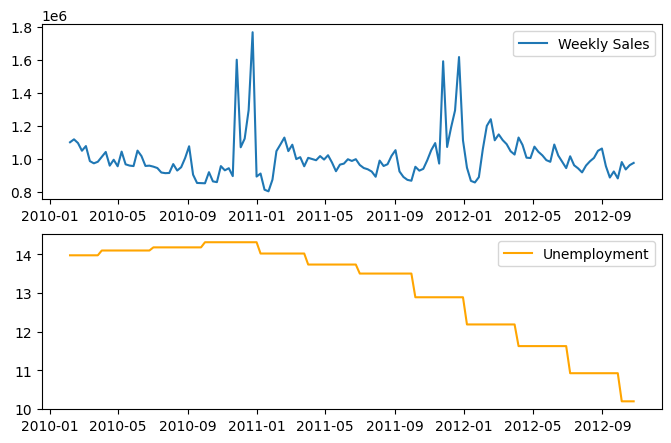

In [198]:
df_store = df[df['store'] == '12']

fig, ax = plt.subplots(2, 1, figsize=(8, 5))
ax[0].plot(df_store['date'], df_store['weekly_sales'], label='Weekly Sales')
ax[1].plot(df_store['date'], df_store['unemployment'], label='Unemployment', color='orange')
ax[0].legend()
ax[1].legend()
plt.show()


No direct correlation observed between sales and unemployment rate. However, seasonal decompose might tell us something

Pearson Correlation between unemployment and weekly sales: -0.11252795058812329
Spearman Correlation between unemployment and weekly sales: -0.1605059665705267
Kendall Correlation between unemployment and weekly sales: -0.11418063280775571
Lag 1 weeks: correlation = -0.11296856483773032
Lag 2 weeks: correlation = -0.12002464793947858
Lag 3 weeks: correlation = -0.13088034105760368
Lag 4 weeks: correlation = -0.13528133119894636


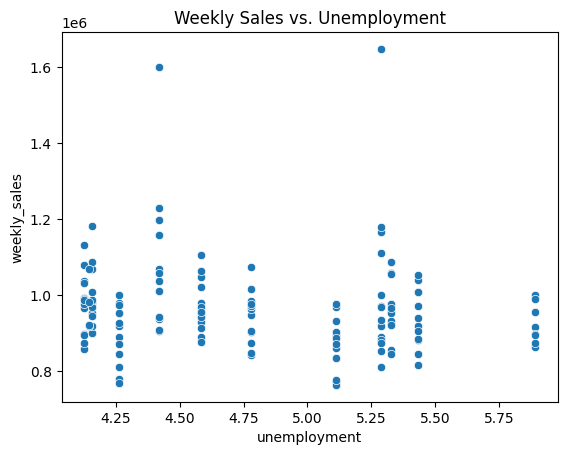

In [190]:
df_store = df[df['store'] == '40']
sns.scatterplot(x='unemployment', y='weekly_sales', data=df_store)
plt.title('Weekly Sales vs. Unemployment')
# plt.show()

pearson = df_store['weekly_sales'].corr(df_store['unemployment'], method='pearson')
print(f"Pearson Correlation between unemployment and weekly sales: {pearson}")

spearman = df_store['weekly_sales'].corr(df_store['unemployment'], method='spearman')
print(f"Spearman Correlation between unemployment and weekly sales: {spearman}")

kendall = df_store['weekly_sales'].corr(df_store['unemployment'], method='kendall')
print(f"Kendall Correlation between unemployment and weekly sales: {kendall}")

for lag in [1, 2, 3, 4]:
    lagged_unemp = df_store['unemployment'].shift(lag)
    lag_corr = df_store['weekly_sales'].corr(lagged_unemp)
    print(f"Lag {lag} weeks: correlation = {lag_corr}")

### Checking how weekly_sales and its trend component are related with unemployment

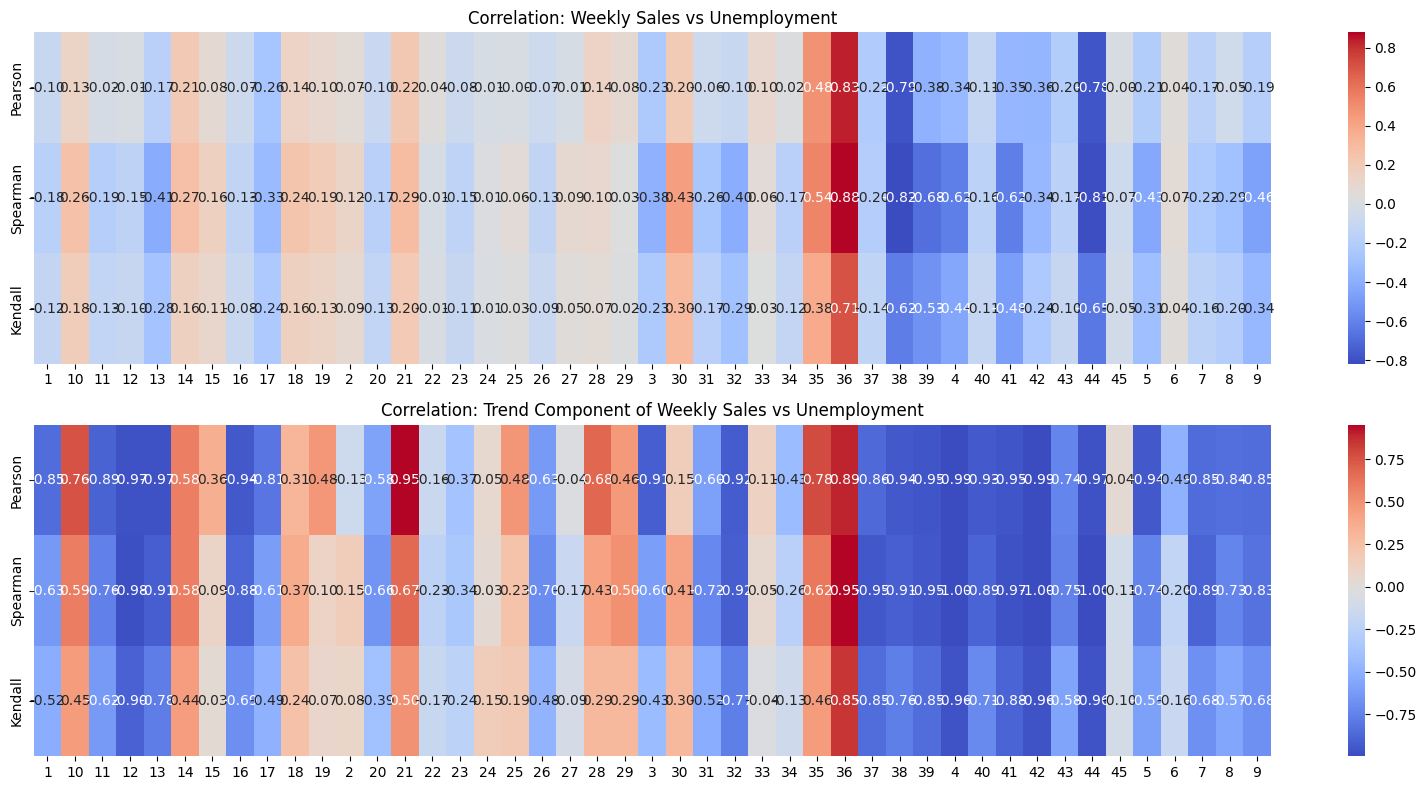

In [216]:
# Extract unique stores
stores = sorted(df['store'].unique())  # Sort for consistent order

# Initialize correlation storage
correlation_sales = pd.DataFrame(index=['Pearson', 'Spearman', 'Kendall'], columns=stores)
correlation_trend = pd.DataFrame(index=['Pearson', 'Spearman', 'Kendall'], columns=stores)

# Compute correlations for each store
for store in stores:
    df_store = df[df['store'] == store].sort_values('date').set_index('date')
    
    # Extract weekly sales and unemployment
    y = df_store['weekly_sales']
    unemployment = df_store['unemployment']
    
    # Compute correlations (Weekly Sales vs Unemployment)
    correlation_sales.loc['Pearson', store] = y.corr(unemployment, method='pearson')
    correlation_sales.loc['Spearman', store] = y.corr(unemployment, method='spearman')
    correlation_sales.loc['Kendall', store] = y.corr(unemployment, method='kendall')

    # Perform STL decomposition
    stl = STL(y, seasonal=53)  # Assuming yearly seasonality
    result = stl.fit()
    
    # Extract trend component
    df_store['trend'] = result.trend
    
    # Compute correlations (Trend vs Unemployment)
    correlation_trend.loc['Pearson', store] = df_store['trend'].corr(unemployment, method='pearson')
    correlation_trend.loc['Spearman', store] = df_store['trend'].corr(unemployment, method='spearman')
    correlation_trend.loc['Kendall', store] = df_store['trend'].corr(unemployment, method='kendall')

# Convert to float type (for better plotting)
correlation_sales = correlation_sales.astype(float)
correlation_trend = correlation_trend.astype(float)

# Plot heatmaps
fig, axes = plt.subplots(2, 1, figsize=(16, 8), gridspec_kw={'height_ratios': [1, 1]})

# Sales vs Unemployment Heatmap
sns.heatmap(correlation_sales, cmap='coolwarm', annot=True, fmt=".2f", ax=axes[0])
axes[0].set_title("Correlation: Weekly Sales vs Unemployment")

# Trend vs Unemployment Heatmap
sns.heatmap(correlation_trend, cmap='coolwarm', annot=True, fmt=".2f", ax=axes[1])
axes[1].set_title("Correlation: Trend Component of Weekly Sales vs Unemployment")

# Adjust layout
plt.tight_layout()
plt.show()


### Observations
Looking at it, the trend component of weekly sales is definitely more correlated with unemployment than regular weekly_sales. But, there's high contrast in how it's correlated. For most of the stores, it's strongly negative. For some other stores it's strongly positive. Few times it's close to zero. So, I'm not sure if it's a good indicator of whether there's a relationship between weekly_sales and unemployment.

## Time Series Decomposition

### Regular Seasonal Decomposition

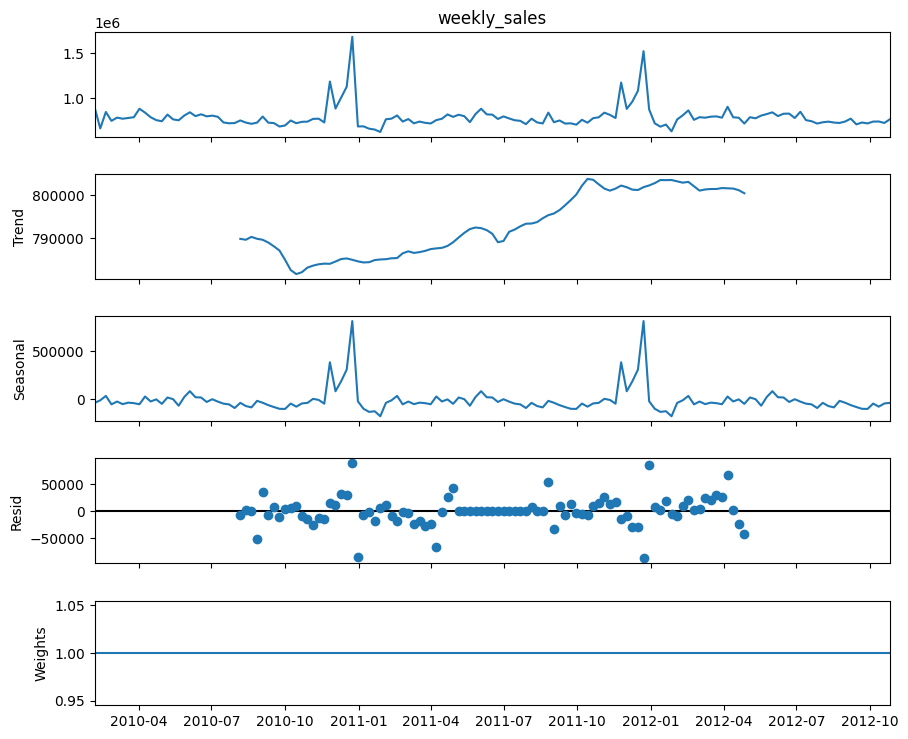

In [ ]:
temp = df.loc[df['store'] == '45'].drop(columns=['store']).sort_values(by=['date']).set_index('date')
sd = seasonal_decompose(
    x = temp['weekly_sales'],
    model='additive',
    # period=52,
)
fig = sd.plot(weights=True)
fig.set_size_inches(10, 8)

### STL Decomposition of weekly_sales for selected stores

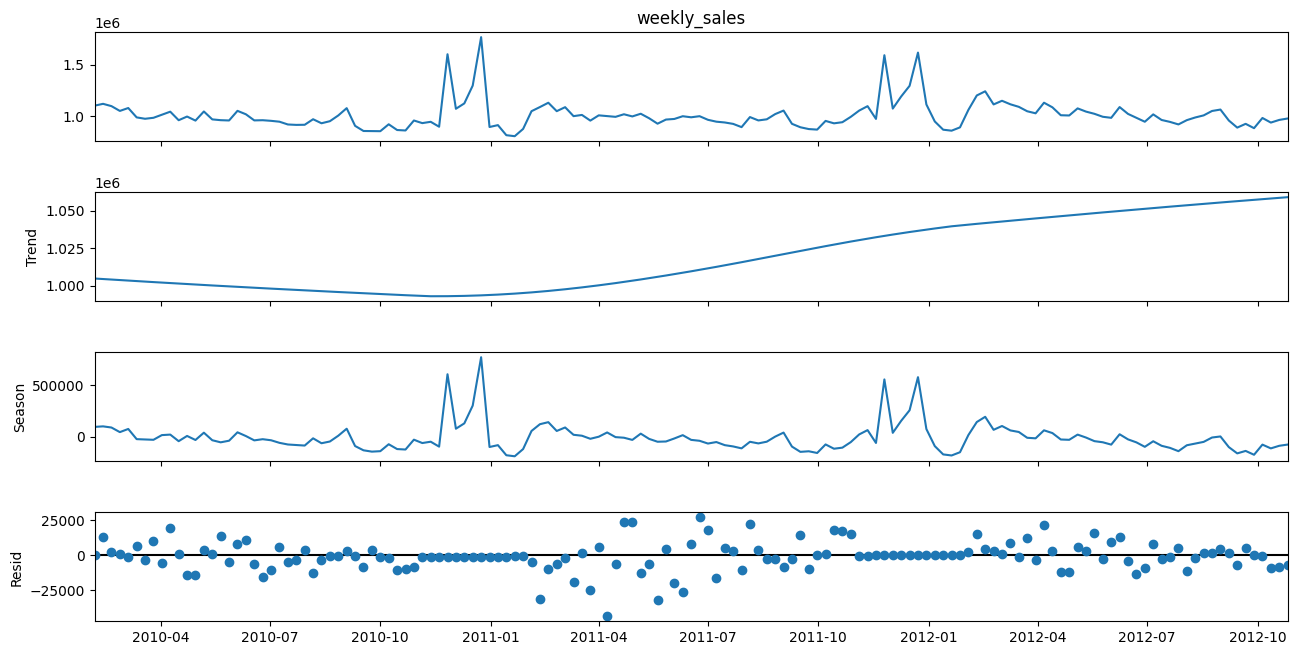

In [26]:
store = '12'
df_store = df[df['store'] == store]
df_store = df_store.sort_values('date').set_index('date')  # ensure chronological order

# Set weekly_sales as the target series
y = df_store['weekly_sales']

# We assume an annual (52-week) seasonal period
stl = STL(y, period = 52, seasonal=53, robust=False, low_pass = 53)
result = stl.fit()

fig = result.plot()
fig.set_size_inches(15, 7)


### Observations 


### MSTL to capture monthly and annual seasonality separately?

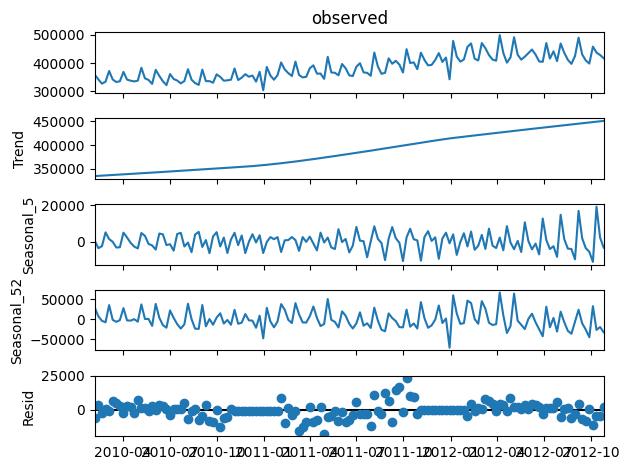

In [66]:

df_store = df[df['store'] == '38']
df_store = df_store.sort_values('date').set_index('date')  # ensure chronological order

# Set weekly_sales as the target series
y = df_store['weekly_sales']

# We assume an annual (52-week) seasonal period
# stl = STL(y, seasonal=53)
# result = stl.fit()
mstl = MSTL(y, periods=[5, 52], iterate=5)
result = mstl.fit()


fig = result.plot()
plt.show()

## Temperature Effect
- Examine if temperature influences weekly sales.

### Checking correlation between weekly_sales and temperature

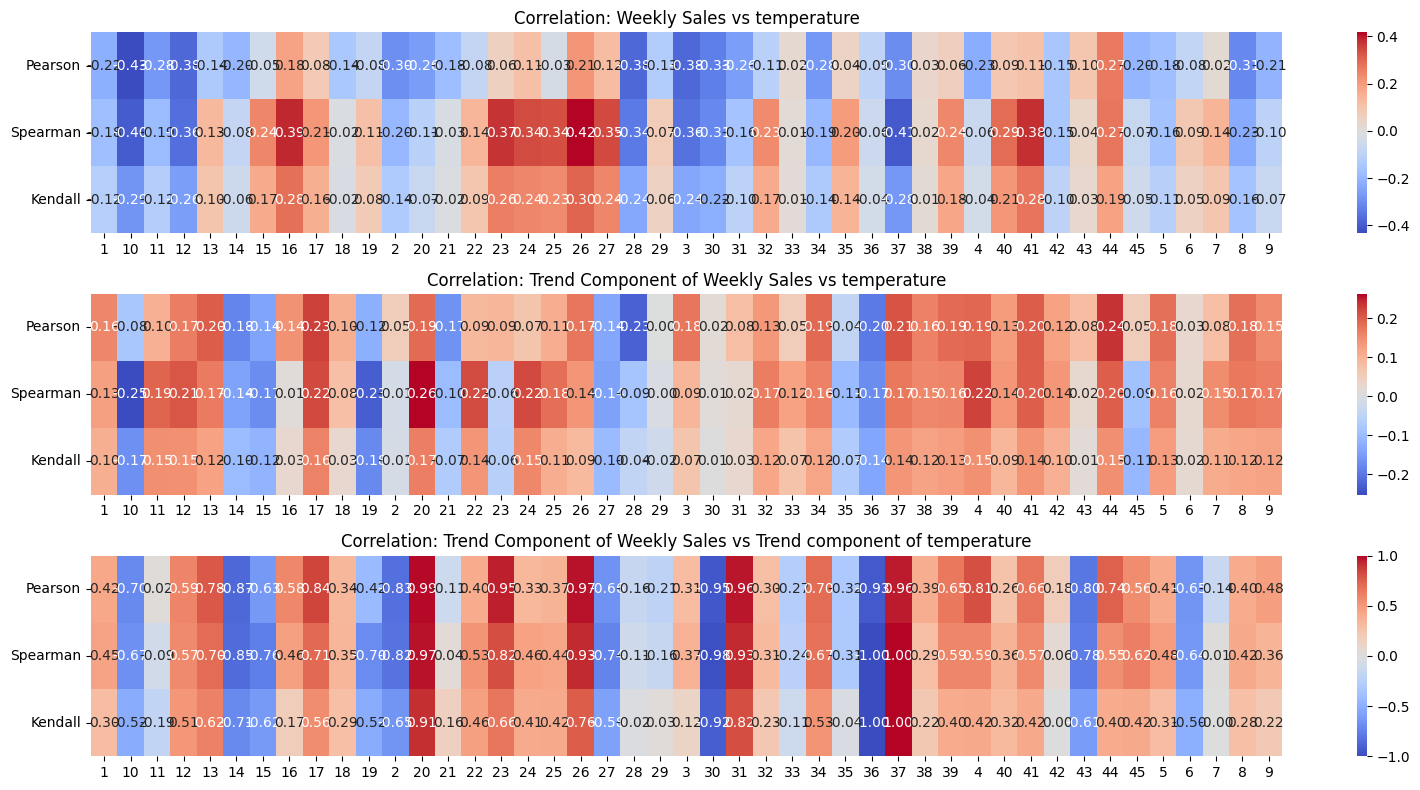

In [264]:
# Extract unique stores
stores = sorted(df['store'].unique())  # Sort for consistent order

# Initialize correlation storage
correlation_sales = pd.DataFrame(index=['Pearson', 'Spearman', 'Kendall'], columns=stores)
correlation_trend = pd.DataFrame(index=['Pearson', 'Spearman', 'Kendall'], columns=stores)
correlation_double_trend = pd.DataFrame(index=['Pearson', 'Spearman', 'Kendall'], columns=stores)

# Compute correlations for each store
for store in stores:
    df_store = df[df['store'] == store].sort_values('date').set_index('date')
    
    # Extract weekly sales and temperature
    y = df_store['weekly_sales']
    temperature = df_store['temperature']
    
    # Compute correlations (Weekly Sales vs Unemployment)
    correlation_sales.loc['Pearson', store] = y.corr(temperature, method='pearson')
    correlation_sales.loc['Spearman', store] = y.corr(temperature, method='spearman')
    correlation_sales.loc['Kendall', store] = y.corr(temperature, method='kendall')

    # Perform STL decomposition
    stl = STL(y, seasonal=53)  # Assuming yearly seasonality
    result = stl.fit()
    
    # Extract trend component
    df_store['trend'] = result.trend
    
    # Compute correlations (Trend vs temperature)
    correlation_trend.loc['Pearson', store] = df_store['trend'].corr(temperature, method='pearson')
    correlation_trend.loc['Spearman', store] = df_store['trend'].corr(temperature, method='spearman')
    correlation_trend.loc['Kendall', store] = df_store['trend'].corr(temperature, method='kendall')

    # Perform STL decomposition
    stl2 = STL(df_store['temperature'], seasonal=53)  # Assuming yearly seasonality
    result = stl2.fit()
    
    # Extract trend component
    df_store['temperature_trend'] = result.trend
    
    # Compute correlations (Trend vs temperature)
    correlation_double_trend.loc['Pearson', store] = df_store['trend'].corr(df_store['temperature_trend'], method='pearson')
    correlation_double_trend.loc['Spearman', store] = df_store['trend'].corr(df_store['temperature_trend'], method='spearman')
    correlation_double_trend.loc['Kendall', store] = df_store['trend'].corr(df_store['temperature_trend'], method='kendall')

# Convert to float type (for better plotting)
correlation_sales = correlation_sales.astype(float)
correlation_trend = correlation_trend.astype(float)
correlation_double_trend = correlation_double_trend.astype(float)

# Plot heatmaps
fig, axes = plt.subplots(3, 1, figsize=(16, 8), gridspec_kw={'height_ratios': [1, 1, 1]})

# Sales vs temperature Heatmap
sns.heatmap(correlation_sales, cmap='coolwarm', annot=True, fmt=".2f", ax=axes[0])
axes[0].set_title("Correlation: Weekly Sales vs temperature")

# Trend vs temperature Heatmap
sns.heatmap(correlation_trend, cmap='coolwarm', annot=True, fmt=".2f", ax=axes[1])
axes[1].set_title("Correlation: Trend Component of Weekly Sales vs temperature")

# Trend vs temperature trend Heatmap
sns.heatmap(correlation_double_trend, cmap='coolwarm', annot=True, fmt=".2f", ax=axes[2])
axes[2].set_title("Correlation: Trend Component of Weekly Sales vs Trend component of temperature")

# Adjust layout
plt.tight_layout()
plt.show()

In [275]:
store = '20'
temp = df.loc[df['store'] == store].drop(columns=['store']).sort_values(by=['date'])
fig = go.Figure()
fig.add_trace(go.Scatter(x=temp['date'], y=temp['weekly_sales'], mode='lines', name='Weekly Sales'))
fig.add_trace(go.Scatter(x=temp['date'], y=temp['temperature']*10000, mode='lines', name='Temperature'))
fig.show()

### Seasonal Decomposition of Temperature

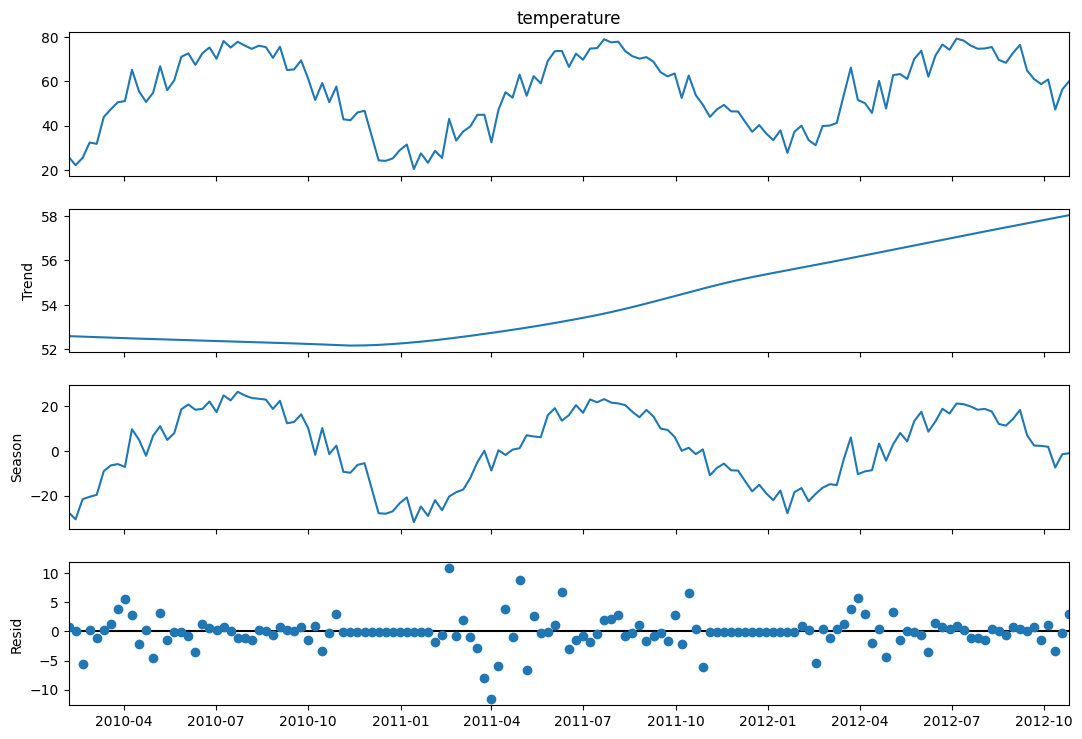

In [276]:
store = '20'
df_store = df[df['store'] == store].sort_values('date').set_index('date')

# Set weekly_sales as the target series
y = df_store['temperature']

# We assume an annual (52-week) seasonal period
stl = STL(y, period = 52, seasonal=53, robust=False, low_pass = 53)
result = stl.fit()

fig = result.plot()
fig.set_size_inches(12, 8)


### Comparing trend components of weekly sales vs. temperature

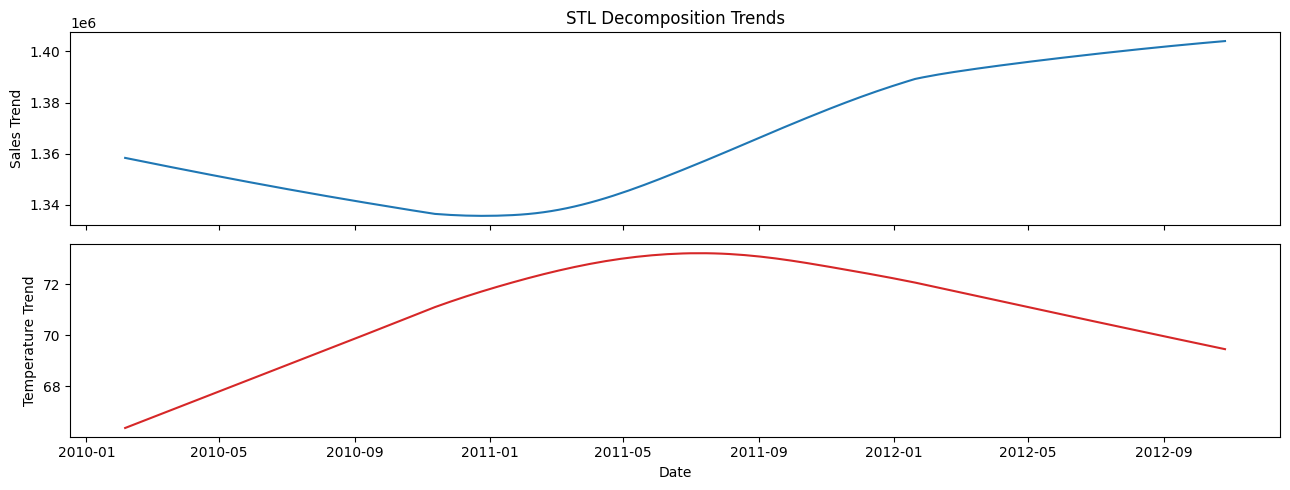

In [295]:
store = '11'
df_store = df[df['store'] == store].sort_values('date').set_index('date')
# Perform STL decomposition for both series
decomp_sales = STL(df_store['weekly_sales'], period=52, seasonal = 53, robust=False).fit()
decomp_temp = STL(df_store['temperature'], period=52, seasonal = 53, robust=False).fit()

# Create stacked subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(13, 5))
ax1.plot(df_store.index, decomp_sales.trend, color='tab:blue')
ax1.set(ylabel='Sales Trend', title='STL Decomposition Trends')
ax2.plot(df_store.index, decomp_temp.trend, color='tab:red')
ax2.set(xlabel='Date', ylabel='Temperature Trend')
plt.tight_layout()
plt.show()

### Observations
- There is no correlation between weekly_sales and temperature

## Consumer Price Index

### Checking correlation between weekly_sales and its trend component with CPI

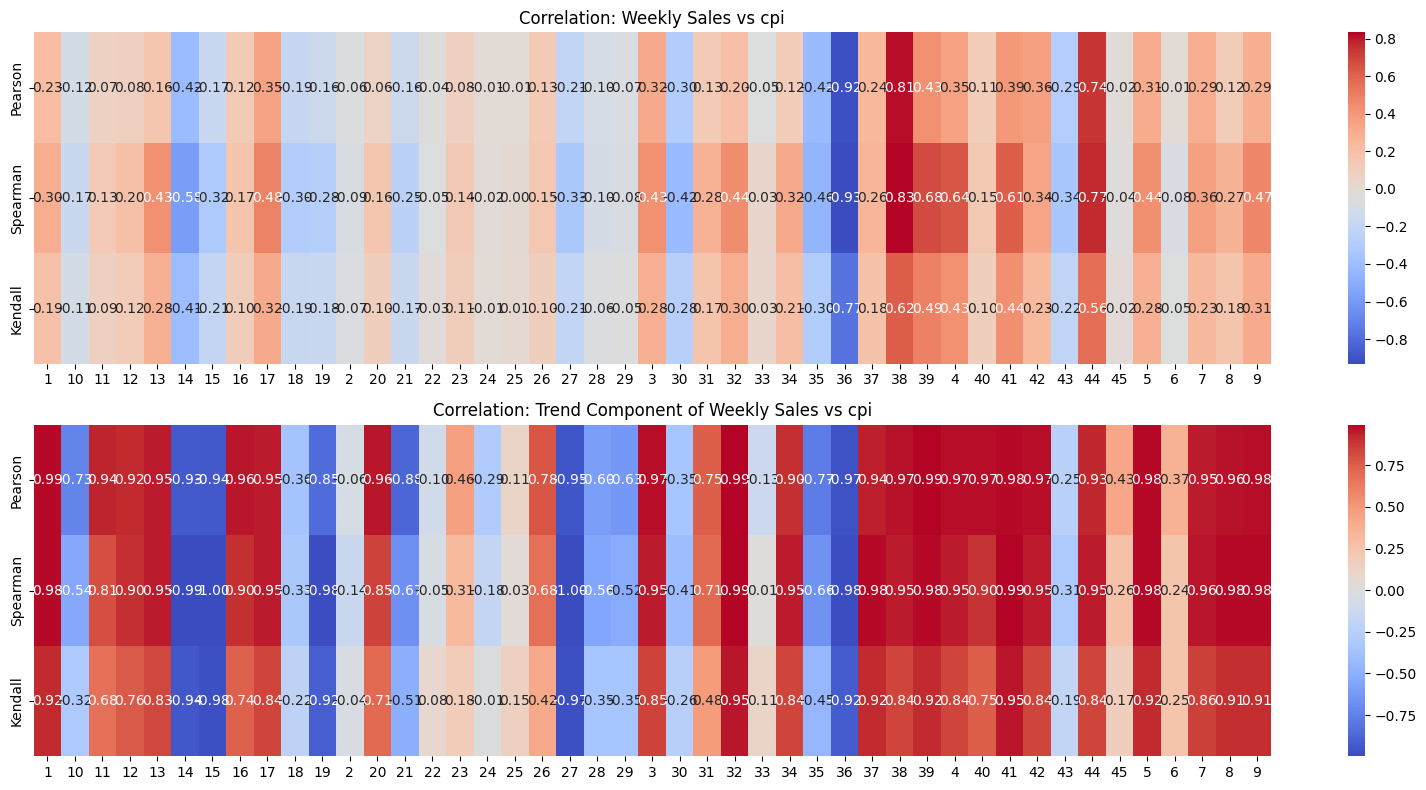

In [286]:
# Extract unique stores
stores = sorted(df['store'].unique())  # Sort for consistent order

# Initialize correlation storage
correlation_sales = pd.DataFrame(index=['Pearson', 'Spearman', 'Kendall'], columns=stores)
correlation_trend = pd.DataFrame(index=['Pearson', 'Spearman', 'Kendall'], columns=stores)

# Compute correlations for each store
for store in stores:
    df_store = df[df['store'] == store].sort_values('date').set_index('date')
    
    # Extract weekly sales and cpi
    y = df_store['weekly_sales']
    cpi = df_store['cpi']
    
    # Compute correlations (Weekly Sales vs Unemployment)
    correlation_sales.loc['Pearson', store] = y.corr(cpi, method='pearson')
    correlation_sales.loc['Spearman', store] = y.corr(cpi, method='spearman')
    correlation_sales.loc['Kendall', store] = y.corr(cpi, method='kendall')

    # Perform STL decomposition
    stl = STL(y, seasonal=53, period = 52, robust=True)  # Assuming yearly seasonality
    result = stl.fit()
    
    # Extract trend component
    df_store['trend'] = result.trend
    
    # Compute correlations (Trend vs cpi)
    correlation_trend.loc['Pearson', store] = df_store['trend'].corr(cpi, method='pearson')
    correlation_trend.loc['Spearman', store] = df_store['trend'].corr(cpi, method='spearman')
    correlation_trend.loc['Kendall', store] = df_store['trend'].corr(cpi, method='kendall')

# Convert to float type (for better plotting)
correlation_sales = correlation_sales.astype(float)
correlation_trend = correlation_trend.astype(float)

# Plot heatmaps
fig, axes = plt.subplots(2, 1, figsize=(16, 8), gridspec_kw={'height_ratios': [1, 1]})

# Sales vs cpi Heatmap
sns.heatmap(correlation_sales, cmap='coolwarm', annot=True, fmt=".2f", ax=axes[0])
axes[0].set_title("Correlation: Weekly Sales vs cpi")

# Trend vs cpi Heatmap
sns.heatmap(correlation_trend, cmap='coolwarm', annot=True, fmt=".2f", ax=axes[1])
axes[1].set_title("Correlation: Trend Component of Weekly Sales vs cpi")

# Adjust layout
plt.tight_layout()
plt.show()

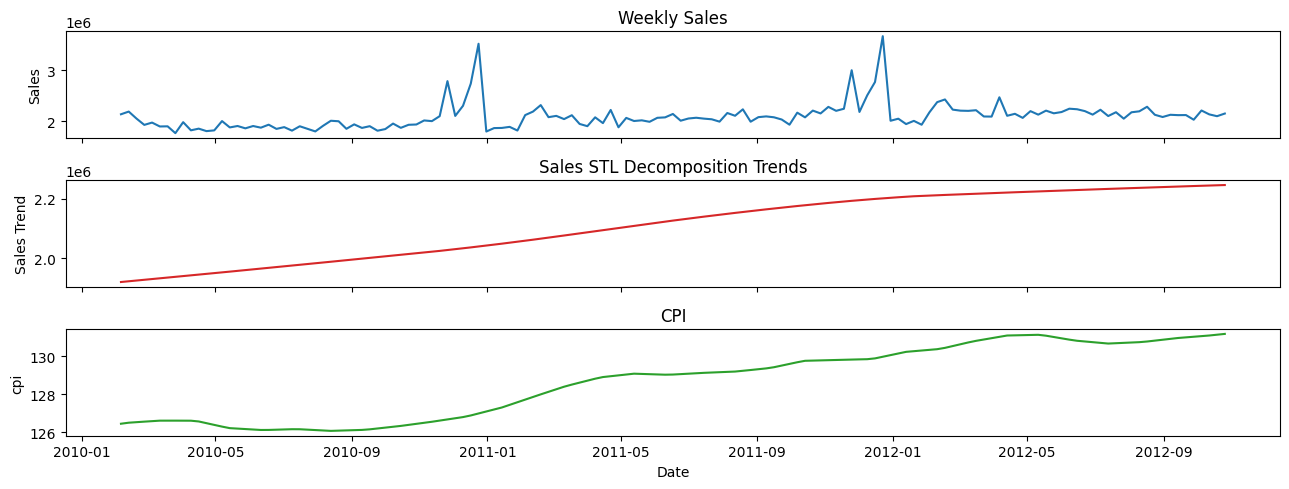

In [334]:
store = '4'
df_store = df[df['store'] == store].sort_values('date').set_index('date')
# Perform STL decomposition for both series
decomp_sales = STL(df_store['weekly_sales'], period=52, seasonal = 53, robust=False).fit()
# decomp_temp = STL(df_store['cpi'], period=52, seasonal = 53, robust=False).fit()
cpi = df_store['cpi']

# Create stacked subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(13, 5))
ax1.plot(df_store.index, df_store['weekly_sales'], color='tab:blue')
ax1.set(ylabel='Sales', title='Weekly Sales')
ax2.plot(df_store.index, decomp_sales.trend, color='tab:red')
ax2.set(ylabel='Sales Trend', title='Sales STL Decomposition Trends')
ax3.plot(df_store.index, cpi, color='tab:green')
ax3.set(xlabel='Date', ylabel='cpi', title='CPI')
plt.tight_layout()
plt.show()

### Observations
- When looking at weekly_sales and cpi directly, the correlations is insignificant. But, when considering only the trend component with respect to CPI, there seems to be a significant correlation.
- Most of the correlations are strongly positive. Very few are strongly negative. And even fewer are weakly positive or negative.
- If for all stores the correlations were in same direction with significant magnitude, then it would hold some meaning. But, it doesn't.

## Fuel Price

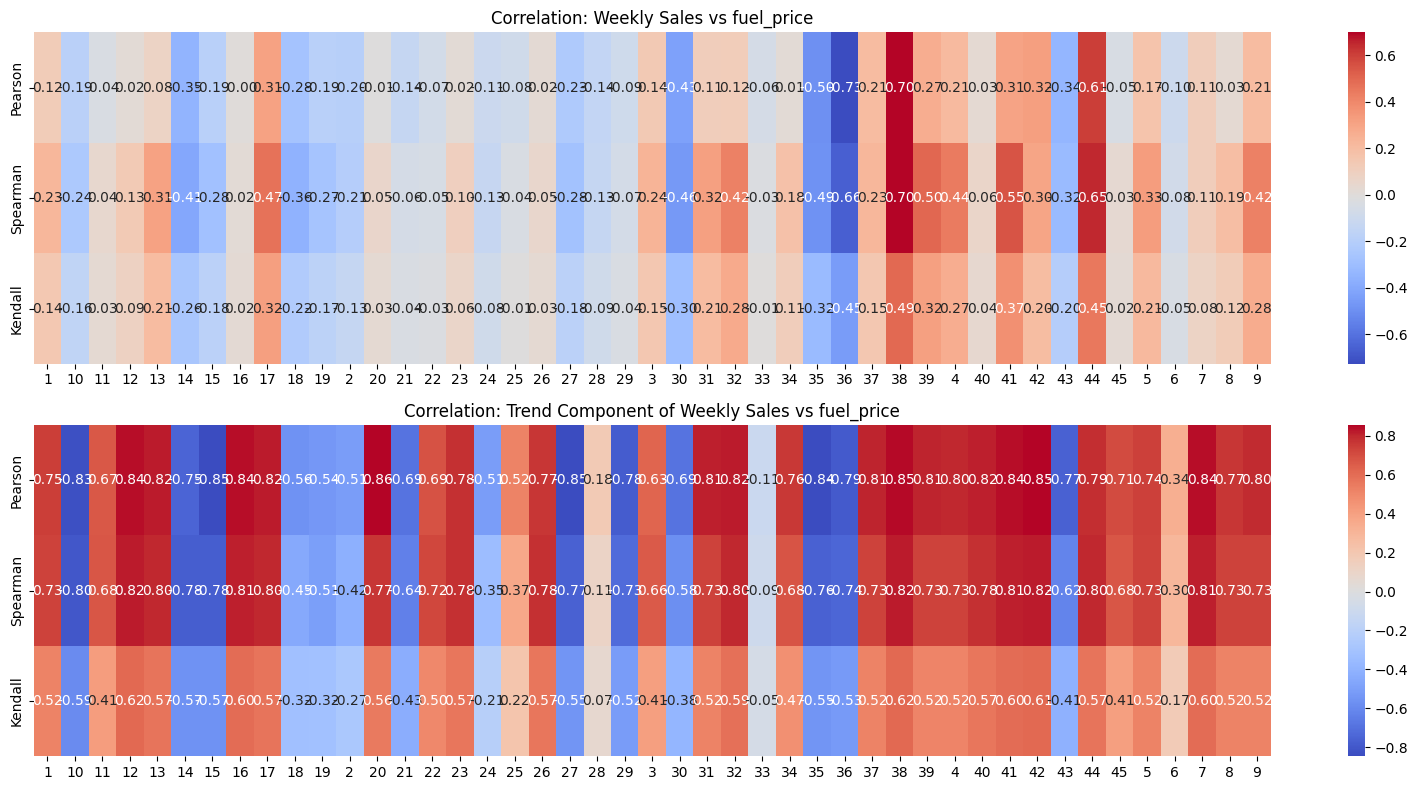

In [ ]:
# Extract unique stores
stores = sorted(df['store'].unique())  # Sort for consistent order

# Initialize correlation storage
correlation_sales = pd.DataFrame(index=['Pearson', 'Spearman', 'Kendall'], columns=stores)
correlation_trend = pd.DataFrame(index=['Pearson', 'Spearman', 'Kendall'], columns=stores)

# Compute correlations for each store
for store in stores:
    df_store = df[df['store'] == store].sort_values('date').set_index('date')
    
    # Extract weekly sales and fuel_price
    y = df_store['weekly_sales']
    fuel_price = df_store['fuel_price']
    
    # Compute correlations (Weekly Sales vs Unemployment)
    correlation_sales.loc['Pearson', store] = y.corr(fuel_price, method='pearson')
    correlation_sales.loc['Spearman', store] = y.corr(fuel_price, method='spearman')
    correlation_sales.loc['Kendall', store] = y.corr(fuel_price, method='kendall')

    # Perform STL decomposition
    stl = STL(y, seasonal=53, period = 52, robust=True)  # Assuming yearly seasonality
    result = stl.fit()
    
    # Extract trend component
    df_store['trend'] = result.trend
    
    # Compute correlations (Trend vs fuel_price)
    correlation_trend.loc['Pearson', store] = df_store['trend'].corr(fuel_price, method='pearson')
    correlation_trend.loc['Spearman', store] = df_store['trend'].corr(fuel_price, method='spearman')
    correlation_trend.loc['Kendall', store] = df_store['trend'].corr(fuel_price, method='kendall')

# Convert to float type (for better plotting)
correlation_sales = correlation_sales.astype(float)
correlation_trend = correlation_trend.astype(float)

# Plot heatmaps
fig, axes = plt.subplots(2, 1, figsize=(16, 8), gridspec_kw={'height_ratios': [1, 1]})

# Sales vs fuel_price Heatmap
sns.heatmap(correlation_sales, cmap='coolwarm', annot=True, fmt=".2f", ax=axes[0])
axes[0].set_title("Correlation: Weekly Sales vs fuel_price")

# Trend vs fuel_price Heatmap
sns.heatmap(correlation_trend, cmap='coolwarm', annot=True, fmt=".2f", ax=axes[1])
axes[1].set_title("Correlation: Trend Component of Weekly Sales vs fuel_price")

# Adjust layout
plt.tight_layout()
plt.show()

## Store Performance Analysis

Performance metrics:
- Total sales and average
- Total relative growth irrespective of seasons and trends
- Total relative growth in terms of trend only
- Stability/consistency of growth


### Performance by Total Sales and Average Weekly Sales

In [325]:
store_sales_summary = (
    df.groupby('store', observed=True)['weekly_sales']
    .agg(total_sales='sum')
    .reset_index()
)

# Rank by total sales
store_sales_summary['rank_by_total'] = store_sales_summary['total_sales'].rank(method='dense', ascending=False)
store_sales_summary.sort_values('rank_by_total', ascending=True, inplace=True)

In [326]:
display(store_sales_summary.head(3))
display(store_sales_summary.tail(3))

store   total_sales  rank_by_total
12    20  3.013978e+08            1.0
33     4  2.995440e+08            2.0
5     14  2.889999e+08            3.0

store  total_sales  rank_by_total
40     5  45475688.90           43.0
38    44  43293087.84           44.0
26    33  37160221.96           45.0

In [327]:
print(
    "Total sales difference between Top performer and worst performer",
    (store_sales_summary['total_sales'].head(1).values[0] - store_sales_summary['total_sales'].tail(1).values[0])
)

Total sales difference between Top performer and worst performer 264237570.49999997


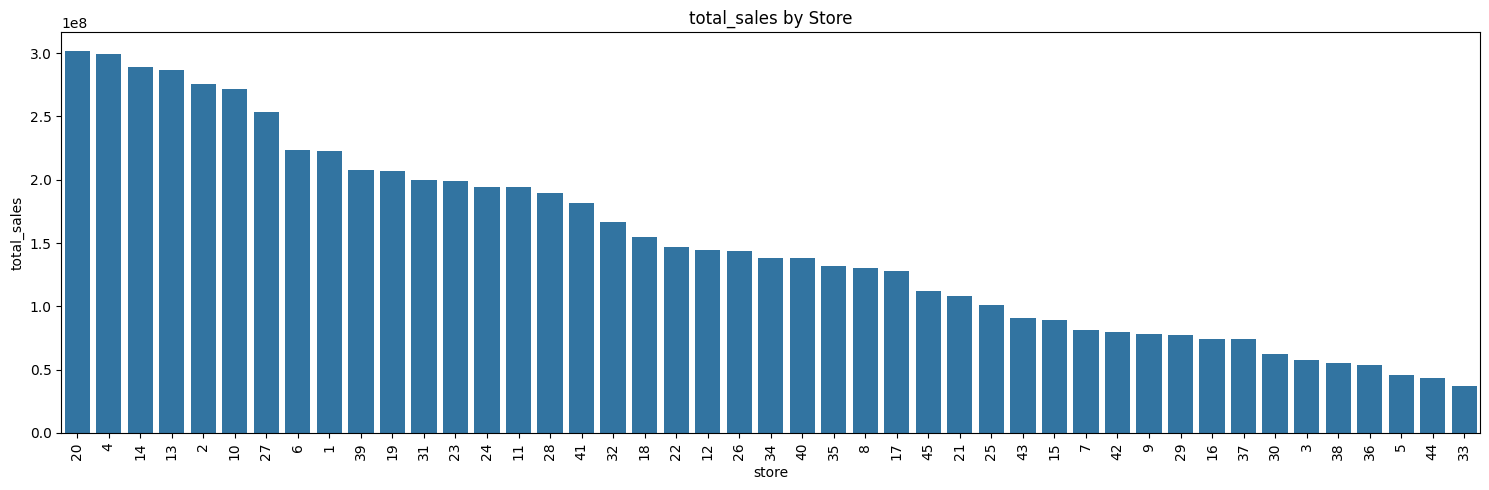

In [328]:
# Sort stores by average weekly sales descending
sorted_df = store_sales_summary.sort_values(by='total_sales', ascending=False)

plt.figure(figsize=(15, 5))
sns.barplot(
    data=sorted_df,
    x='store',
    y='total_sales',
    order=sorted_df['store']
)
plt.title('total_sales by Store')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Performance by Relative percentage growth of weekly_sales, slope of linear trend of sales, and volatility of weekly_sales

In [ ]:
from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LinearRegression
# import numpy as np

stores = df['store'].unique()
performance_records = []

for store_id in stores:
    # 1. Subset data
    df_store = df.loc[df['store'] == store_id].copy()
    df_store = df_store.sort_values(by='date').set_index('date')
    
    # 3. Decompose using STL (assuming ~52-week season)
    stl = STL(df_store['weekly_sales'], period=52, robust=False)
    res = stl.fit()
    
    df_store['trend'] = res.trend
    df_store['seasonal'] = res.seasonal
    df_store['remainder'] = res.resid
    
    # 4. Compute Trend Slope (via Linear Regression)
    # Create a numeric index for regression
    df_store['t'] = np.arange(len(df_store))
    model = LinearRegression()
    model.fit(df_store[['t']], df_store['trend'])
    slope = model.coef_[0]
    
    # 5. Compute % Growth from first to last
    # start_trend = (df_store['trend'] + df_store['remainder']).iloc[0]
    # end_trend   = (df_store['trend'] + df_store['remainder']).iloc[-1]
    start_trend = df_store['trend'].iloc[0]
    end_trend   = df_store['trend'].iloc[-1]
    pct_growth  = ((end_trend - start_trend) / start_trend) * 100 if start_trend != 0 else np.nan
    
    # 6. Compute remainder volatility
    remainder_std = df_store['remainder'].std()
    
    # 7. Collect performance metrics
    performance_records.append({
        'store': store_id,
        'avg_sales': df_store['weekly_sales'].mean(),
        'trend_slope': slope,
        'pct_growth': pct_growth,
        'remainder_std': remainder_std
    })

performance_df = pd.DataFrame(performance_records)
performance_df.head()

store     avg_sales  trend_slope  pct_growth  remainder_std
0     1  1.555264e+06  1127.123073   10.576742   19954.534906
1     2  1.925751e+06  -183.998161   -1.092796   25281.026206
2     3  4.027044e+05   381.561748   13.388005    6438.841433
3     4  2.094713e+06  2627.792816   18.642148   27465.255272
4     5  3.180118e+05   348.752243   16.094950    6004.317210

In [361]:
store = '27'
df_store = df[df['store'] == store].sort_values('date')

px.line(df_store, x='date', y='weekly_sales', title=f'Weekly Sales for Store {store}')

In [356]:
performance_df['remainder_std'].describe()

count       45.000000
mean     18596.482677
std      12099.531399
min       3970.786743
25%       9303.368510
50%      15246.908518
75%      25281.026206
max      55791.164638
Name: remainder_std, dtype: float64

### Creating a composite score for stores based on multiple metrics

In [358]:
def rank_performance(performance_df):
    # Higher is better
    performance_df['rank_avg_sales'] = performance_df['avg_sales'].rank(method='dense', ascending=False)
    performance_df['rank_slope'] = performance_df['trend_slope'].rank(method='dense', ascending=False)
    performance_df['rank_pct_growth'] = performance_df['pct_growth'].rank(method='dense', ascending=False)
    
    # Lower is better for volatility
    performance_df['rank_volatility'] = performance_df['remainder_std'].rank(method='dense', ascending=True)
    
    # Example: Weighted sum of ranks
    performance_df['overall_rank_score'] = (
        # performance_df['rank_avg_sales'] +
        performance_df['rank_slope'] +
        performance_df['rank_pct_growth']
        # performance_df['rank_volatility']*0.5
    )
    
    performance_df['overall_rank'] = performance_df['overall_rank_score'].rank(method='dense', ascending=True)
    return performance_df

performance_df = rank_performance(performance_df)
display(performance_df.sort_values('overall_rank').head(5))
display(performance_df.sort_values('overall_rank').tail(5))

store     avg_sales  trend_slope  pct_growth  remainder_std  \
38    39  1.450668e+06  2547.940064   26.746144   25266.711024   
3      4  2.094713e+06  2627.792816   18.642148   27465.255272   
40    41  1.268125e+06  1826.762167   23.133839   15574.345371   
37    38  3.857317e+05   908.811651   37.187433    6380.756744   
16    17  8.935814e+05  1055.973471   17.191642   11344.546549   

    rank_avg_sales  rank_slope  rank_pct_growth  rank_volatility  \
38            10.0         2.0              2.0             33.0   
3              2.0         1.0              6.0             38.0   
40            17.0         3.0              4.0             25.0   
37            41.0         7.0              1.0              6.0   
16            27.0         6.0              7.0             15.0   

    overall_rank_score  overall_rank  
38                 4.0           1.0  
3                  7.0           2.0  
40                 7.0           2.0  
37                 8.0           3.0  
16                13.0           4.0

store     avg_sales  trend_slope  pct_growth  remainder_std  \
14    15  6.233125e+05  -493.985782  -10.920997   13314.326975   
26    27  1.775216e+06 -1311.624966  -10.222337   43670.221023   
13    14  2.020978e+06 -2814.300956  -19.985543   55791.164638   
35    36  3.735120e+05 -1378.938067  -40.048354    7702.493100   
34    35  9.197250e+05 -2036.214554  -25.641675   26204.581997   

    rank_avg_sales  rank_slope  rank_pct_growth  rank_volatility  \
14            32.0        40.0             42.0             20.0   
26             7.0        42.0             41.0             43.0   
13             3.0        45.0             43.0             45.0   
35            42.0        43.0             45.0              9.0   
34            25.0        44.0             44.0             36.0   

    overall_rank_score  overall_rank  
14                82.0          34.0  
26                83.0          35.0  
13                88.0          36.0  
35                88.0          36.0  
34                88.0          36.0

### Conclusions
- By analyzing the equally weighted scores of different metrics, stores [39, 4, 41, 17] are the top 3 performers in terms of sales and stores [15, 27, 14, 36, 35] seem to be the worst performers.

## Checking correlation between unemployment, fuel_price and cpi

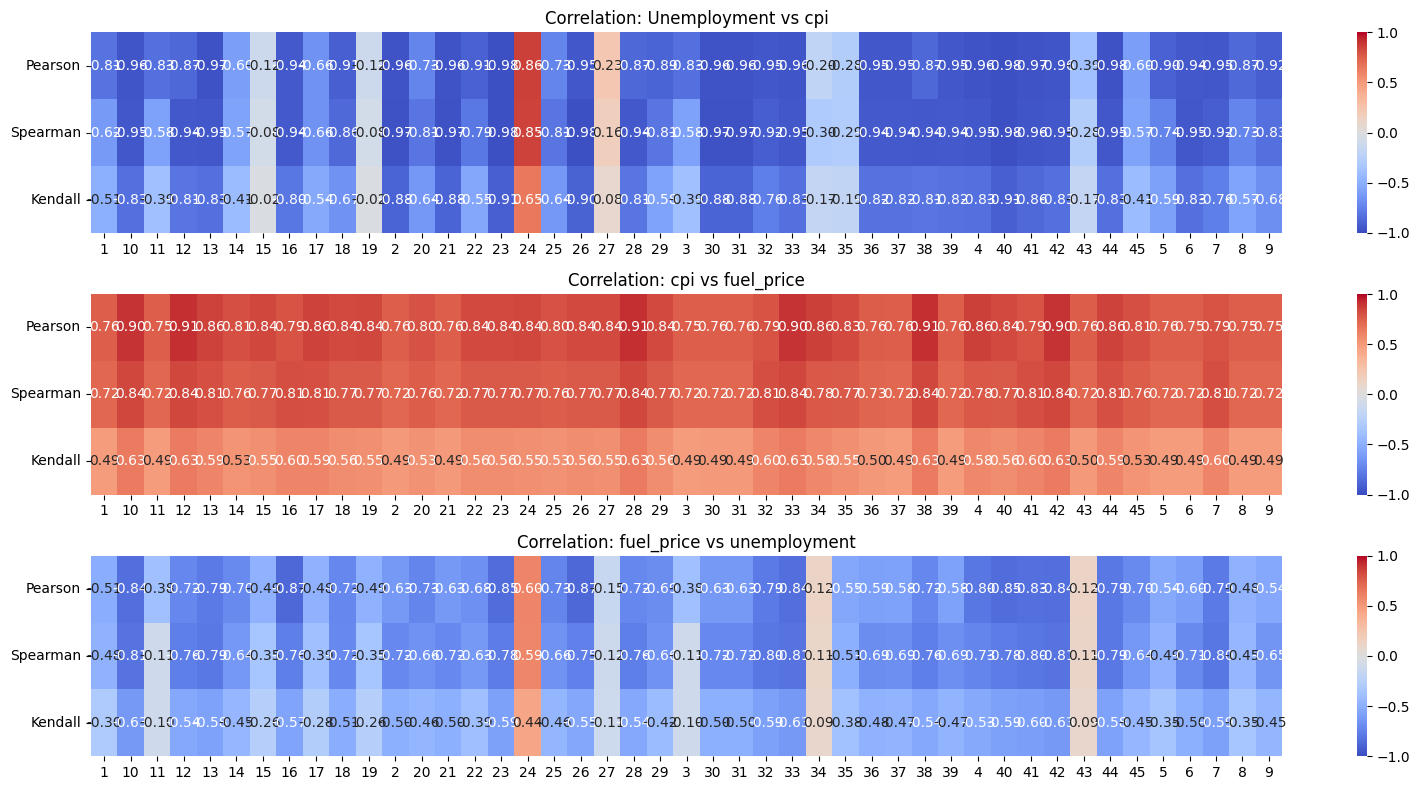

In [ ]:
# Extract unique stores
stores = sorted(df['store'].unique())  # Sort for consistent order

# Initialize correlation storage
unemployment_cpi = pd.DataFrame(index=['Pearson', 'Spearman', 'Kendall'], columns=stores)
cpi_fuel_price = pd.DataFrame(index=['Pearson', 'Spearman', 'Kendall'], columns=stores)
fuel_price_unemployment = pd.DataFrame(index=['Pearson', 'Spearman', 'Kendall'], columns=stores)

# Compute correlations for each store
for store in stores:
    df_store = df[df['store'] == store].sort_values('date').set_index('date')
    
    # Compute correlations (Unemployment vs CPI)
    unemployment_cpi.loc['Pearson', store] = df_store['unemployment'].corr(df_store['cpi'], method='pearson')
    unemployment_cpi.loc['Spearman', store] = df_store['unemployment'].corr(df_store['cpi'], method='spearman')
    unemployment_cpi.loc['Kendall', store] = df_store['unemployment'].corr(df_store['cpi'], method='kendall')

    # Compute correlations (CPI vs Fuel Price)
    cpi_fuel_price.loc['Pearson', store] = df_store['cpi'].corr(df_store['fuel_price'], method='pearson')
    cpi_fuel_price.loc['Spearman', store] = df_store['cpi'].corr(df_store['fuel_price'], method='spearman')
    cpi_fuel_price.loc['Kendall', store] = df_store['cpi'].corr(df_store['fuel_price'], method='kendall')
    
    # Compute correlations (Fuel Price vs Unemployment)
    fuel_price_unemployment.loc['Pearson', store] = df_store['fuel_price'].corr(df_store['unemployment'], method='pearson')
    fuel_price_unemployment.loc['Spearman', store] = df_store['fuel_price'].corr(df_store['unemployment'], method='spearman')
    fuel_price_unemployment.loc['Kendall', store] = df_store['fuel_price'].corr(df_store['unemployment'], method='kendall')


# Convert to float type (for better plotting)
unemployment_cpi = unemployment_cpi.astype(float)
cpi_fuel_price = cpi_fuel_price.astype(float)
fuel_price_unemployment = fuel_price_unemployment.astype(float)


# Plot heatmaps
fig, axes = plt.subplots(3, 1, figsize=(16, 8), gridspec_kw={'height_ratios': [1, 1, 1]})

# Unemployment vs cpi Heatmap
sns.heatmap(unemployment_cpi, cmap='coolwarm', annot=True, fmt=".2f", ax=axes[0], vmin=-1, vmax=1)
axes[0].set_title("Correlation: Unemployment vs cpi")

# CPI vs fuel_price Heatmap
sns.heatmap(cpi_fuel_price, cmap='coolwarm', annot=True, fmt=".2f", ax=axes[1], vmin=-1, vmax=1)
axes[1].set_title("Correlation: cpi vs fuel_price")

# Fuel Price vs unemployment Heatmap
sns.heatmap(fuel_price_unemployment, cmap='coolwarm', annot=True, fmt=".2f", ax=axes[2], vmin=-1, vmax=1)
axes[2].set_title("Correlation: fuel_price vs unemployment")

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
cpi_fuel_price.loc['Pearson'].mean()

np.float64(0.814384248770184)

In [ ]:
display(unemployment_cpi.loc['Pearson'].describe())
display(unemployment_cpi.loc['Pearson'].quantile(0.85))

count    45.000000
mean     -0.754107
std       0.374793
min      -0.977855
25%      -0.960864
50%      -0.909667
75%      -0.732422
max       0.862500
Name: Pearson, dtype: float64

np.float64(-0.5136435870365372)

In [ ]:
display(fuel_price_unemployment.loc['Pearson'].describe())

count    45.000000
mean     -0.597719
std       0.288258
min      -0.873024
25%      -0.787313
50%      -0.679553
75%      -0.538876
max       0.596955
Name: Pearson, dtype: float64

In [ ]:
store = '42'
df_store = df.loc[df['store'] == store].copy()
# px.scatter_3d(df_store, x = 'cpi', y='unemployment', z = 'fuel_price')
px.scatter(df_store, x = 'cpi', y='fuel_price', color = 'unemployment')

### Observations
1. CPI and Fuel price are strongly positively correlated with each other for ALL stores with average Pearson correlation coefficient of 0.814. This is intuitive because fuel pice is generally considered when calculating CPI.
2. Unemployment and CPI are negatively correlated for most stores. For 75% of then stores, the correlation is greater in magnitude than 0.73 and for 85% of the stores it's greater in magnitude than 0.51. But, for the rest of the stores, the correlation gets closer to zero. And for store 24, the correlation is strongly positive with the coefficient being 0.86
3. Fuel Price and Unemployment are negatively correlated for most stores. This correltion isn't as strong as Unemployment and CPI. For 75% of then stores, the correlation is greater in magnitude than 0.53. But, for the rest of the stores, the correlation gets closer to zero. And for store 24, the correlation is strongly positive with the coefficient being 0.6

## PCA with CPI, Fuel Price, and Unemployment

### Why?
- PCA is used for dimensionality reduction. And while it may seem like we don't have that high dimensional data with only 5 features, but the fact that we are forecasting the sales store wise makes it so that we have only 143 rows/observations per store with 5 features.
- And that's too little data for us to consider 5 exogenous variables. So we can try to reduce the dimensionality of our data and see if it works.



In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Group by store
stores = df['store'].unique()

# Let's create a structure to hold the PCA results for each store
store_pca_results = {}

for store_id in stores:
    # Filter data for that store
    df_store = df[df['store'] == store_id].copy()
    
    # Sort by date to ensure proper time ordering (if not already)
    df_store.sort_values(by='date', inplace=True)
    
    # 2. Extract the 3 correlated features
    X = df_store[['cpi', 'fuel_price', 'unemployment']].values
    
    # 3. Standardize the features (very important for PCA!)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 4. Apply PCA
    pca = PCA(n_components=2)  # We'll fit up to 3, but we might keep fewer
    pca.fit(X_scaled)
    
    # 5. Get the transformed principal components
    # shape: (num_weeks, 3)
    X_pca = pca.transform(X_scaled)
    
    # 6. Check explained variance
    explained_variance = pca.explained_variance_ratio_
    
    # We can store these results
    store_pca_results[store_id] = {
        'pca_object': pca,
        'scaler': scaler,
        'explained_variance': explained_variance,
        'principal_components': X_pca
    }

    # OPTIONAL: You can add these principal components back to df_store
    # if you want them as features in your next model.
    df_store['PC1'] = X_pca[:, 0]
    df_store['PC2'] = X_pca[:, 1]
    # df_store['PC3'] = X_pca[:, 2]
    
    # Then you might store or export df_store with these new columns
    # e.g., store the modified DataFrame in a dictionary or list
    store_pca_results[store_id]['df_with_pcs'] = df_store


In [ ]:
store_pca_results.get('10').get('explained_variance')

array([0.93470124, 0.05600219])

In [ ]:
store_pca_results.get('10').get('pca_object').components_

array([[ 0.59025544,  0.56443428, -0.57707231],
       [-0.18649252,  0.79090418,  0.58283027]])

In [ ]:
df_store = store_pca_results.get('10').get('df_with_pcs').copy()
px.scatter(df_store, x='PC1', y='PC2', title='Stores PCA', color='cpi')

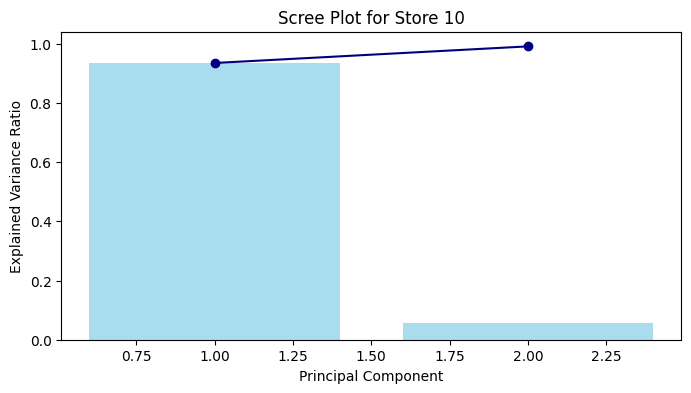

In [ ]:
def plot_scree(store_id):
    pca = store_pca_results[store_id]['pca_object']
    explained_var = pca.explained_variance_ratio_
    
    plt.figure(figsize=(8,4))
    plt.bar(range(1, len(explained_var)+1), explained_var, color='skyblue', alpha=0.7)
    plt.plot(range(1, len(explained_var)+1), np.cumsum(explained_var), marker='o', color='navy')
    plt.title(f'Scree Plot for Store {store_id}')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.show()

plot_scree('10')


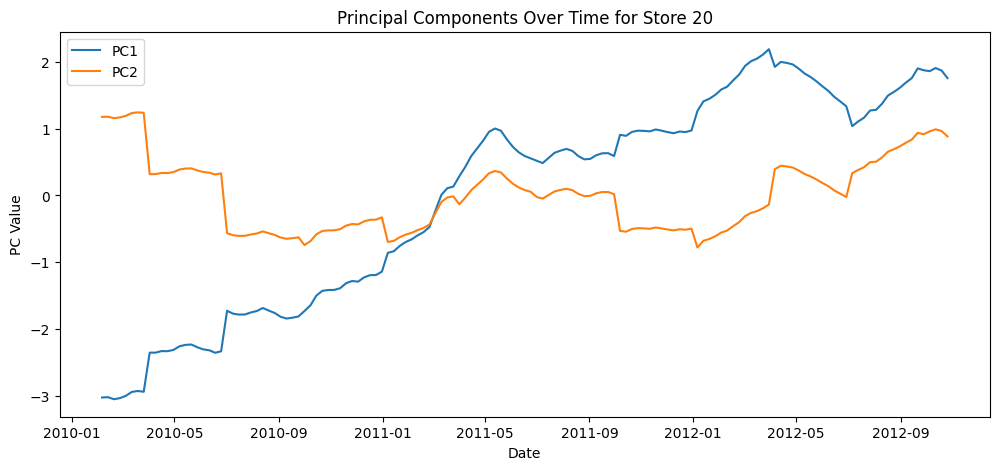

In [ ]:
def plot_pcs_time(store_id):
    df_store = store_pca_results[store_id]['df_with_pcs']
    plt.figure(figsize=(12,5))
    plt.plot(df_store['date'], df_store['PC1'], label='PC1')
    plt.plot(df_store['date'], df_store['PC2'], label='PC2')
    # plt.plot(df_store['date'], StandardScaler().fit_transform(df['weekly_sales']), label='sales')
    # plt.plot(df_store['date'], df_store['PC3'], label='PC3')
    plt.title(f'Principal Components Over Time for Store {store_id}')
    plt.xlabel('Date')
    plt.ylabel('PC Value')
    plt.legend()
    plt.show()

plot_pcs_time('20')


In [ ]:
pc1_explained_var = []
pc2_explained_var = []

for key, value in store_pca_results.items():
    pc1_explained_var.append(value['explained_variance'][0])
    pc2_explained_var.append(value['explained_variance'][1])

explained_var = pd.DataFrame({'PC1': pc1_explained_var, 'PC2': pc2_explained_var})
explained_var['total'] = explained_var['PC1'] + explained_var['PC2']

In [ ]:
explained_var.describe()

PC1        PC2      total
count  45.000000  45.000000  45.000000
mean    0.837000   0.142385   0.979385
std     0.087777   0.082199   0.015858
min     0.603096   0.056002   0.933382
25%     0.803809   0.087022   0.972884
50%     0.857133   0.135813   0.983690
75%     0.895186   0.158574   0.990703
max     0.934701   0.365466   0.994236

### Conclusion/Observations

- The 3 features cpi, unemployment and fuel_price are reduced to 2 principal components which on average (across all stores) explains 97% variance across the 3 features.
- When I tried reducing the features to just 1 principal component, I got worse results where on average (across all stores) the variance explained was only 83%

## Stationarity

- ADF test
- KPSS test

### Transformations

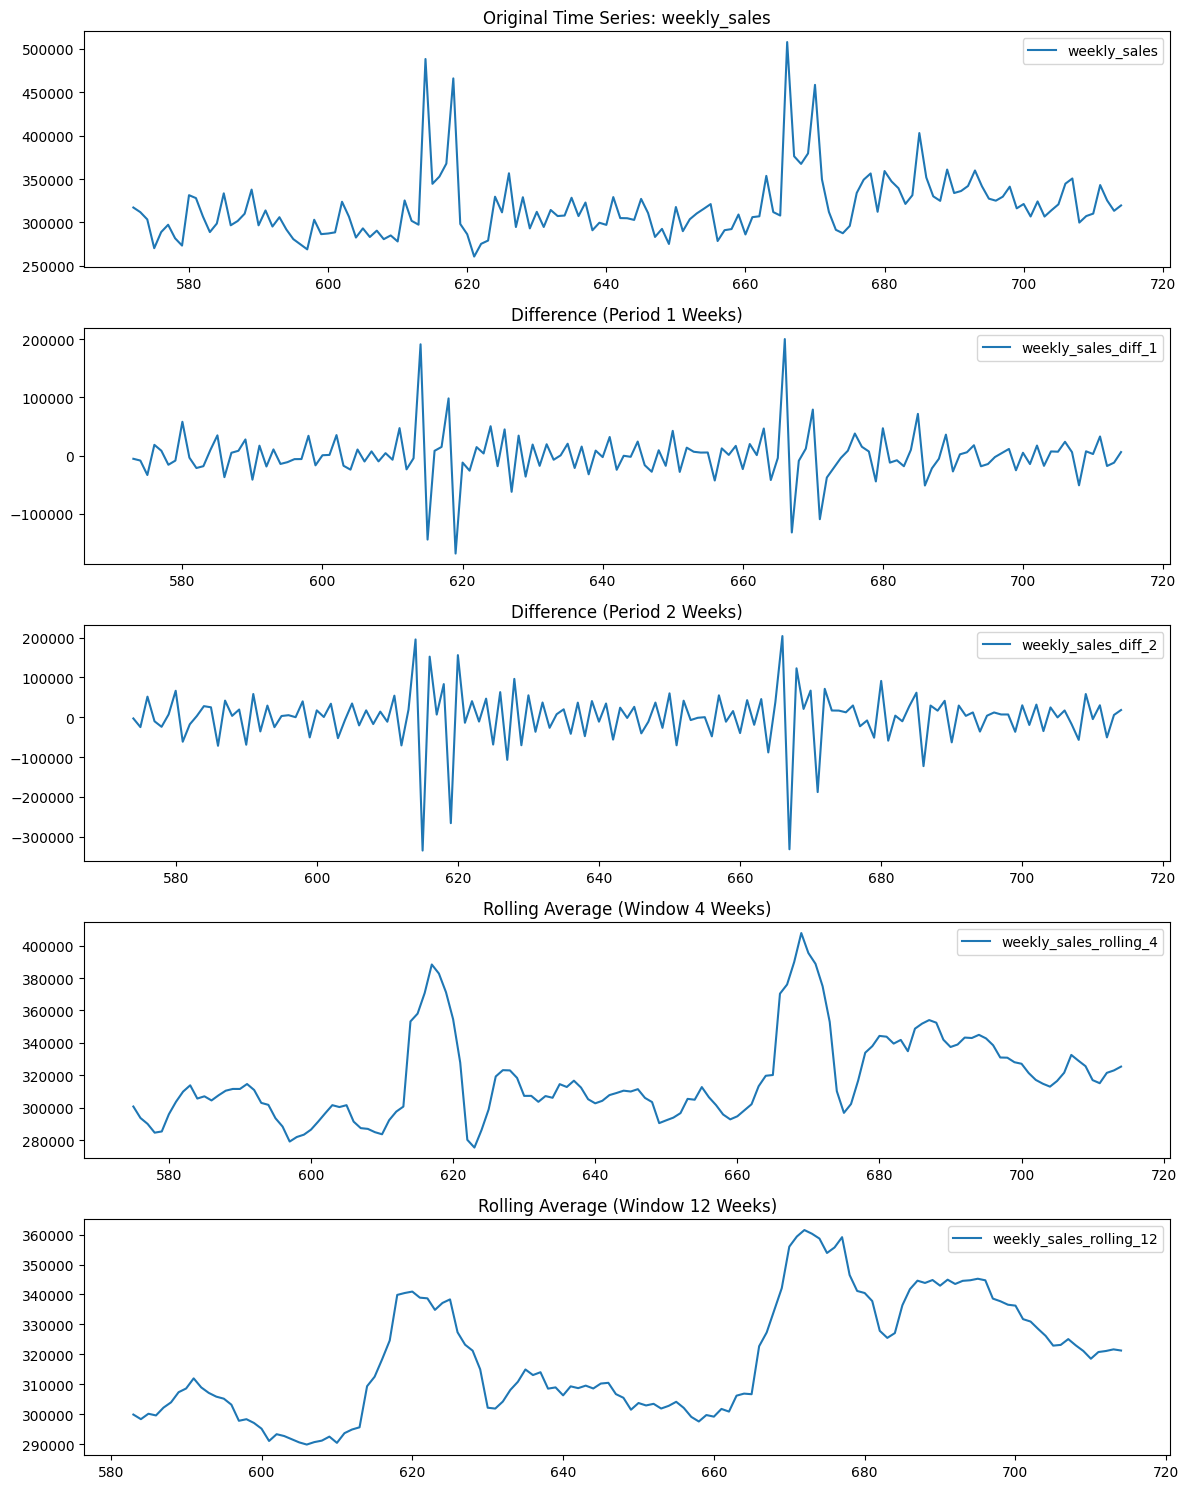

In [ ]:
store = '5'
df_store = df.loc[df['store'] == store].copy()

time_series_col = 'weekly_sales'
periods_diff = [1, 2]  # Number of times for differencing
periods_lag = [1, 4]  # Number of weeks for lags
window_sizes = [4, 12]  # Number of weeks for rolling averages

# Create difference transformations
df_store[f"{time_series_col}_diff_1"] = df_store[time_series_col].diff(periods=1).copy()
df_store[f"{time_series_col}_diff_2"] = df_store[f"{time_series_col}_diff_1"].diff(periods=1).copy()

# # Create lag transformations
# for period in periods_lag:
#     df_store[f"{time_series_col}_lag_{period}"] = df_store[time_series_col].shift(periods=period).copy()

# Create rolling average transformations
for window in window_sizes:
    df_store[f"{time_series_col}_rolling_{window}"] = (
        df_store[time_series_col].rolling(window=window).mean()
    ).copy()

# Plotting
num_plots = 1 + len(periods_diff) + len(window_sizes)
fig, axes = plt.subplots(num_plots, 1, figsize=(12, 3 * num_plots))  # Adjusted figsize

# Plot original time series
axes[0].plot(df_store.index, df_store[time_series_col], label=time_series_col)
axes[0].set_title(f"Original Time Series: {time_series_col}")
axes[0].legend()

# Plot difference transformations
for i, period in enumerate(periods_diff):
    col_name = f"{time_series_col}_diff_{period}"
    axes[i + 1].plot(df_store.index, df_store[col_name], label=col_name)
    axes[i + 1].set_title(f"Difference (Period {period} Weeks)")
    axes[i + 1].legend()

# # Plot lag transformations
# for i, period in enumerate(periods_lag):
#     col_name = f"{time_series_col}_lag_{period}"
#     axes[len(periods_diff) + i + 1].plot(df_store.index, df_store[col_name], label=col_name)
#     axes[len(periods_diff) + i + 1].set_title(f"Lag (Period {period} Weeks)")
#     axes[len(periods_diff) + i + 1].legend()

# Plot rolling average transformations
for i, window in enumerate(window_sizes):
    col_name = f"{time_series_col}_rolling_{window}"
    axes[len(periods_diff) + i + 1].plot(
        df_store.index, df_store[col_name], label=col_name
    )
    axes[len(periods_diff) + i + 1].set_title(
        f"Rolling Average (Window {window} Weeks)"
    )
    axes[len(periods_diff) + i + 1].legend()

plt.tight_layout()
plt.show()


### Seasonal Decomposition of Differences and Rolling averages

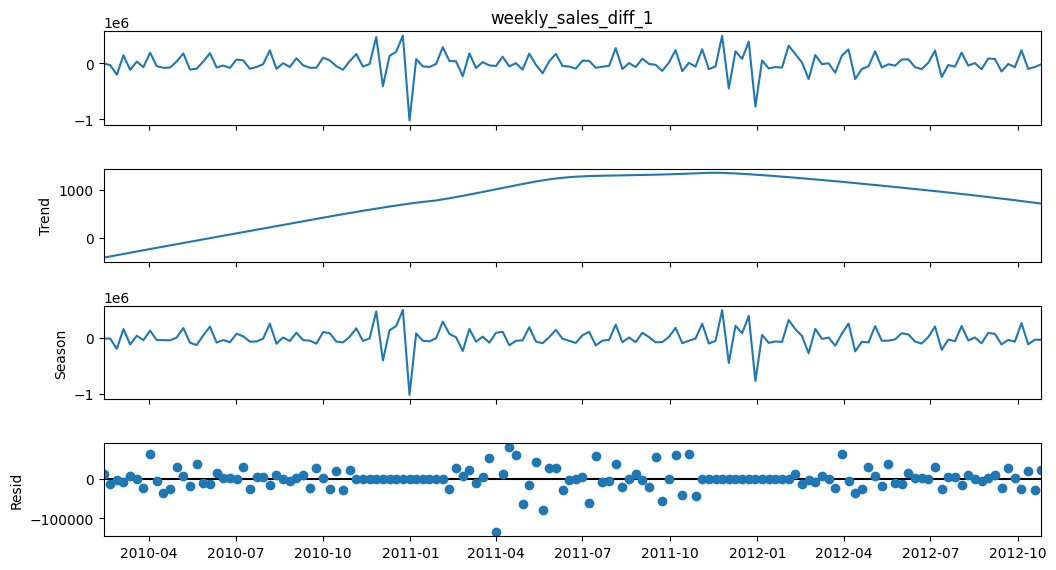

In [ ]:
store = '1'
df_store = df.loc[df['store'] == store].copy()
df_store.set_index('date', inplace=True)

time_series_col = 'weekly_sales'
periods_diff = [1, 2]  # Number of weeks for differencing
window_sizes = [2, 4, 6]  # Number of weeks for rolling averages

# Create difference transformations
df_store[f"{time_series_col}_diff_1"] = df_store[time_series_col].diff(periods=1).copy()
df_store[f"{time_series_col}_diff_2"] = df_store[f"{time_series_col}_diff_1"].diff(periods=1).copy()

# Create rolling average transformations
for window in window_sizes:
    df_store[f"{time_series_col}_rolling_{window}"] = (
        df_store[time_series_col].rolling(window=window).mean()
    ).copy()

y = df_store[f"{time_series_col}_diff_1"].dropna()

# We assume an annual (52-week) seasonal period
stl = STL(y, period = 52, robust=False)
result = stl.fit()

fig = result.plot()
fig.set_size_inches(12, 6)

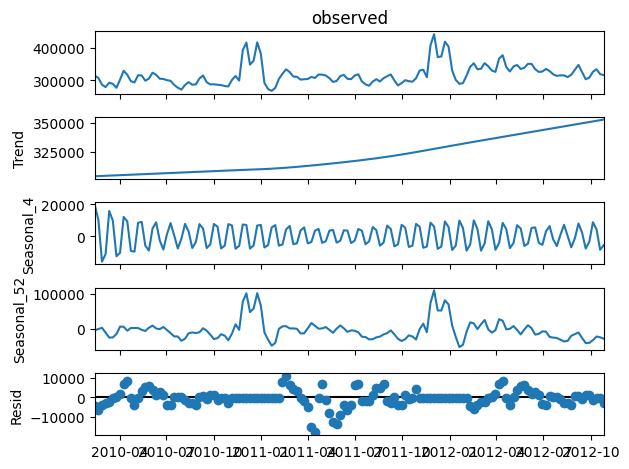

In [ ]:
mstl = MSTL(y, periods=[4, 52], iterate=5)
result = mstl.fit()

fig = result.plot()
plt.show()

### Seasonal Differencing

In [ ]:
def seasonal_difference(
    df: pd.DataFrame, store_num: str, period: int = 52
) -> pd.DataFrame:
    """
    Calculates the seasonal difference for a given store's weekly sales.

    Args:
        df (pd.DataFrame): The input DataFrame containing the data.
        store_num (str): The store number to filter the data for.
        period (int): The seasonal period (default is 52 for weekly data).

    Returns:
        pd.DataFrame: A DataFrame with the original data and the seasonal
                      difference.
    """
    store_df = df[df['store'] == store_num].copy()
    store_df = store_df.sort_values(by='date')
    store_df['seasonal_diff'] = store_df['weekly_sales'].diff(periods=period)
    # store_df = store_df.dropna()  # Remove rows with NaN due to differencing
    return store_df


def visualize_seasonal_difference_plotly(
    df: pd.DataFrame, store_num: str
) -> None:
    """
    Visualizes the original weekly sales and the seasonal difference using Plotly.

    Args:
        df (pd.DataFrame): The DataFrame containing the data and
                             seasonal difference.
        store_num (str): The store number for the visualization title.
    """

    fig = make_subplots(specs=[[{"secondary_y": False}]])

    fig.add_trace(
        go.Scatter(
            x=df['date'],
            y=df['weekly_sales'],
            mode='lines',
            name='Original Weekly Sales',
        ),
        secondary_y=False,
    )

    fig.add_trace(
        go.Scatter(
            x=df['date'],
            y=df['seasonal_diff'],
            mode='lines',
            name='Seasonal Difference (52 weeks)',
        ),
        secondary_y=False,
    )

    fig.update_layout(
        title_text=f'Weekly Sales and Seasonal Difference for Store {store_num}'
    )

    fig.update_xaxes(title_text='Date')
    fig.update_yaxes(title_text='Sales', secondary_y=False)

    fig.show()


store_number = '2'  
df_diff = seasonal_difference(df, store_number)
visualize_seasonal_difference_plotly(df_diff, store_number)



### ADF and KPSS test for stationarity

In [18]:
from statsmodels.tsa.stattools import adfuller, kpss

# Define helper functions for ADF and KPSS tests
def run_adf(series):
    """
    Run the Augmented Dickey-Fuller test on a time series.
    Returns a dictionary with test statistic, p-value, used lags,
    number of observations, critical values, and the best information criterion.
    """
    result = adfuller(series, autolag='AIC')
    return {
        "adf_stat": result[0],
        "p_value": result[1],
        "n_lags": result[2],
        "n_obs": result[3],
        "crit_1%": result[4].get("1%"),
        "crit_5%": result[4].get("5%"),
        "crit_10%": result[4].get("10%"),
        "ic_best": result[5]  # information criterion used for lag selection
    }

def run_kpss(series, regression="c"):
    """
    Run the KPSS test on a time series.
    Returns a dictionary with test statistic, p-value, used lags,
    and critical values.
    Note: regression can be set to "c" (constant) or "ct" (constant and trend).
    """
    result = kpss(series, regression=regression, nlags="auto")
    return {
        "kpss_stat": result[0],
        "p_value": result[1],
        "n_lags": result[2],
        "crit_10%": result[3].get("10%"),
        "crit_5%": result[3].get("5%"),
        "crit_2.5%": result[3].get("2.5%"),
        "crit_1%": result[3].get("1%")
    }

# Containers for storing results for each test and differencing order
adf_diff1_results = []
adf_diff2_results = []
kpss_diff1_results = []
kpss_diff2_results = []

# Assuming df is your already cleaned DataFrame with columns:
# ['store', 'date', 'weekly_sales', 'holiday_flag', 'temperature',
#  'fuel_price', 'cpi', 'unemployment']
# and that the 'store' column is of category dtype.

for store in df["store"].cat.categories:
    # Subset data for the store and sort by date
    store_data = df[df["store"] == store].sort_values("date")
    sales_series = store_data["weekly_sales"]

    # Compute first and second differences (drop the NaN at the beginning)
    diff1 = sales_series.diff(1).dropna()
    diff2 = sales_series.diff(2).dropna()

    # Run tests and capture the results.
    # Using try/except to catch any errors (e.g., if the series is too short)
    adf_res1 = run_adf(diff1)
    adf_res2 = run_adf(diff2)
    kpss_res1 = run_kpss(diff1, regression="c")
    kpss_res2 = run_kpss(diff2, regression="c")

    # Add a reference to the store (to facilitate grouping later)
    adf_res1["store"] = store
    adf_res2["store"] = store
    kpss_res1["store"] = store
    kpss_res2["store"] = store

    adf_diff1_results.append(adf_res1)
    adf_diff2_results.append(adf_res2)
    kpss_diff1_results.append(kpss_res1)
    kpss_diff2_results.append(kpss_res2)

# Create DataFrames (using store as index)
adf_diff1_df = pd.DataFrame(adf_diff1_results).set_index("store")
adf_diff2_df = pd.DataFrame(adf_diff2_results).set_index("store")
kpss_diff1_df = pd.DataFrame(kpss_diff1_results).set_index("store")
kpss_diff2_df = pd.DataFrame(kpss_diff2_results).set_index("store")

# Get descriptive summaries for each test and differencing order.
# The describe() output uses as index: count, mean, std, min, 25%, 50%, 75%, max.
adf_diff1_summary = adf_diff1_df.describe()
adf_diff2_summary = adf_diff2_df.describe()
kpss_diff1_summary = kpss_diff1_df.describe()
kpss_diff2_summary = kpss_diff2_df.describe()

C:\Users\bhagy\AppData\Local\Temp\ipykernel_31840\2053681415.py:29: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\bhagy\AppData\Local\Temp\ipykernel_31840\2053681415.py:29: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\bhagy\AppData\Local\Temp\ipykernel_31840\2053681415.py:29: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\bhagy\AppData\Local\Temp\ipykernel_31840\2053681415.py:29: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\bhagy\AppData\Local\Temp\ipykernel_31840\20

In [19]:
adf_diff1_summary

adf_stat       p_value     n_lags       n_obs    crit_1%    crit_5%  \
count  45.000000  4.500000e+01  45.000000   45.000000  45.000000  45.000000   
mean   -6.888685  1.637536e-04   6.733333  134.266667  -3.480035  -2.883326   
std     1.601953  5.246314e-04   2.480836    2.480836   0.000956   0.000416   
min   -13.345453  5.807075e-25   2.000000  127.000000  -3.482920  -2.884580   
25%    -7.487731  4.591485e-11   5.000000  134.000000  -3.480119  -2.883362   
50%    -7.053856  5.438761e-10   7.000000  134.000000  -3.480119  -2.883362   
75%    -6.567946  8.070202e-09   7.000000  136.000000  -3.479372  -2.883037   
max    -3.812654  2.780473e-03  14.000000  139.000000  -3.478294  -2.882568   

        crit_10%      ic_best  
count  45.000000    45.000000  
mean   -2.578388  3278.859720  
std     0.000222   231.917915  
min    -2.579058  2725.440942  
25%    -2.578407  3208.775174  
50%    -2.578407  3339.947073  
75%    -2.578234  3428.869715  
max    -2.577983  3544.995400

In [20]:
adf_diff2_summary

adf_stat       p_value     n_lags       n_obs    crit_1%    crit_5%  \
count  45.000000  4.500000e+01  45.000000   45.000000  45.000000  45.000000   
mean   -5.915064  6.169749e-03   8.022222  131.977778  -3.480935  -2.883717   
std     1.421504  2.594016e-02   3.602328    3.602328   0.001408   0.000612   
min    -8.678118  4.359889e-14   2.000000  126.000000  -3.483346  -2.884766   
25%    -7.143230  3.282740e-10   5.000000  129.000000  -3.482088  -2.884219   
50%    -5.806791  4.496992e-07   9.000000  131.000000  -3.481282  -2.883868   
75%    -5.132804  1.203890e-05  11.000000  135.000000  -3.479743  -2.883198   
max    -2.333016  1.615407e-01  14.000000  138.000000  -3.478648  -2.882722   

        crit_10%      ic_best  
count  45.000000    45.000000  
mean   -2.578597  3262.797691  
std     0.000327   228.548549  
min    -2.579156  2720.287960  
25%    -2.578864  3192.138229  
50%    -2.578677  3324.474716  
75%    -2.578320  3412.071615  
max    -2.578065  3525.435008

In [24]:
adf_diff2_df.loc[adf_diff2_df['p_value'] > 0.05]

adf_stat   p_value  n_lags  n_obs   crit_1%   crit_5%  crit_10%  \
store                                                                    
33    -2.816371  0.055973      13    127 -3.482920 -2.884580 -2.579058   
38    -2.333016  0.161541      14    126 -3.483346 -2.884766 -2.579156   

          ic_best  
store              
33     2720.28796  
38     2848.62810

In [21]:
kpss_diff1_summary

kpss_stat    p_value      n_lags      crit_10%       crit_5%  \
count  45.000000  45.000000   45.000000  4.500000e+01  4.500000e+01   
mean    0.149684   0.098210   37.577778  3.470000e-01  4.630000e-01   
std     0.082114   0.009235   23.288203  5.613842e-17  5.613842e-17   
min     0.057553   0.041667   15.000000  3.470000e-01  4.630000e-01   
25%     0.105590   0.100000   25.000000  3.470000e-01  4.630000e-01   
50%     0.130501   0.100000   31.000000  3.470000e-01  4.630000e-01   
75%     0.155536   0.100000   43.000000  3.470000e-01  4.630000e-01   
max     0.500000   0.100000  141.000000  3.470000e-01  4.630000e-01   

          crit_2.5%       crit_1%  
count  4.500000e+01  4.500000e+01  
mean   5.740000e-01  7.390000e-01  
std    1.122768e-16  1.122768e-16  
min    5.740000e-01  7.390000e-01  
25%    5.740000e-01  7.390000e-01  
50%    5.740000e-01  7.390000e-01  
75%    5.740000e-01  7.390000e-01  
max    5.740000e-01  7.390000e-01

In [22]:
kpss_diff2_summary

kpss_stat    p_value      n_lags      crit_10%       crit_5%  \
count  45.000000  45.000000   45.000000  4.500000e+01  4.500000e+01   
mean    0.088154   0.098704   20.377778  3.470000e-01  4.630000e-01   
std     0.088579   0.008696   23.698186  5.613842e-17  5.613842e-17   
min     0.015239   0.041667    4.000000  3.470000e-01  4.630000e-01   
25%     0.040464   0.100000   11.000000  3.470000e-01  4.630000e-01   
50%     0.065140   0.100000   15.000000  3.470000e-01  4.630000e-01   
75%     0.095313   0.100000   19.000000  3.470000e-01  4.630000e-01   
max     0.500000   0.100000  140.000000  3.470000e-01  4.630000e-01   

          crit_2.5%       crit_1%  
count  4.500000e+01  4.500000e+01  
mean   5.740000e-01  7.390000e-01  
std    1.122768e-16  1.122768e-16  
min    5.740000e-01  7.390000e-01  
25%    5.740000e-01  7.390000e-01  
50%    5.740000e-01  7.390000e-01  
75%    5.740000e-01  7.390000e-01  
max    5.740000e-01  7.390000e-01

## ACF and PACF

- ARIMA candidates
    - Difference 1 (d = 1)
        - AR orders (PACF) [6]
        - MA orders (ACF) [4, 5]
    - Difference 2 (d = 2)
        - AR orders (PACF) [6, 9]
        - MA orders (ACF) [4, 5]
    
- SARIMA candidates
    - Seasonal Difference 1 (D = 1)
        - AR orders (PACF) [3]
        - MA orders (ACF) [5]


Plotting ACF & PACF for original


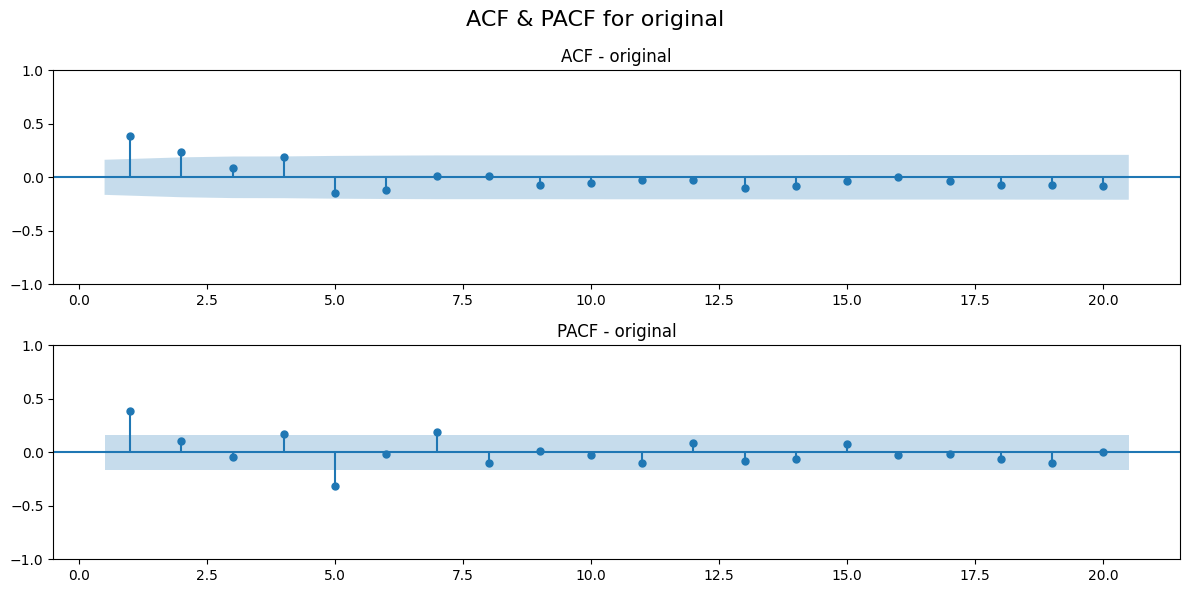

Plotting ACF & PACF for diff_1


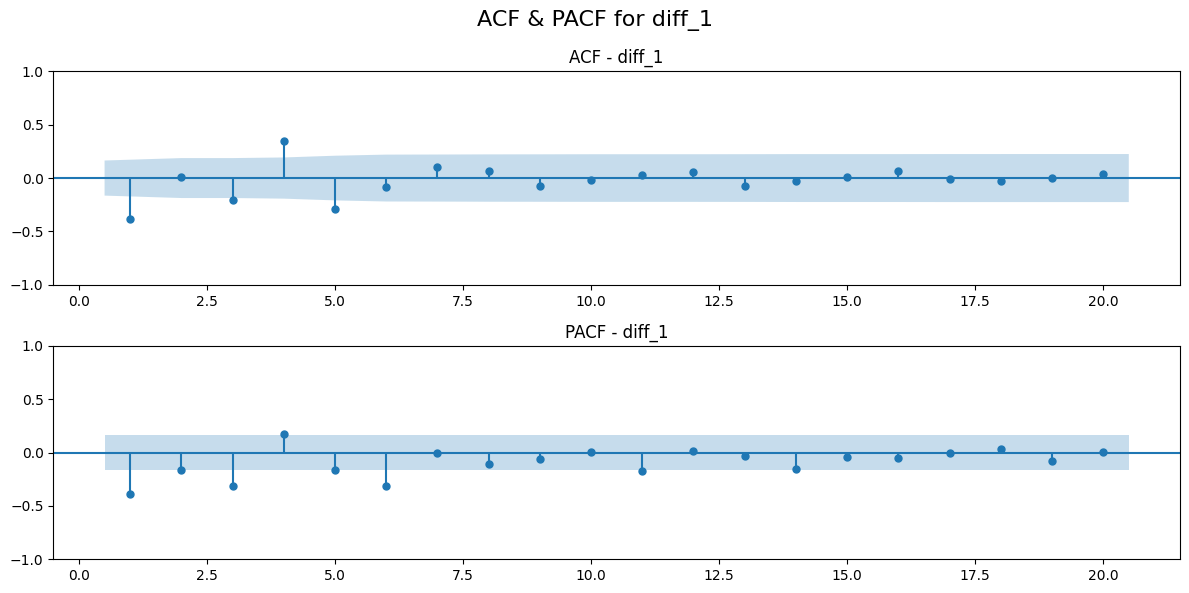

Plotting ACF & PACF for diff_2


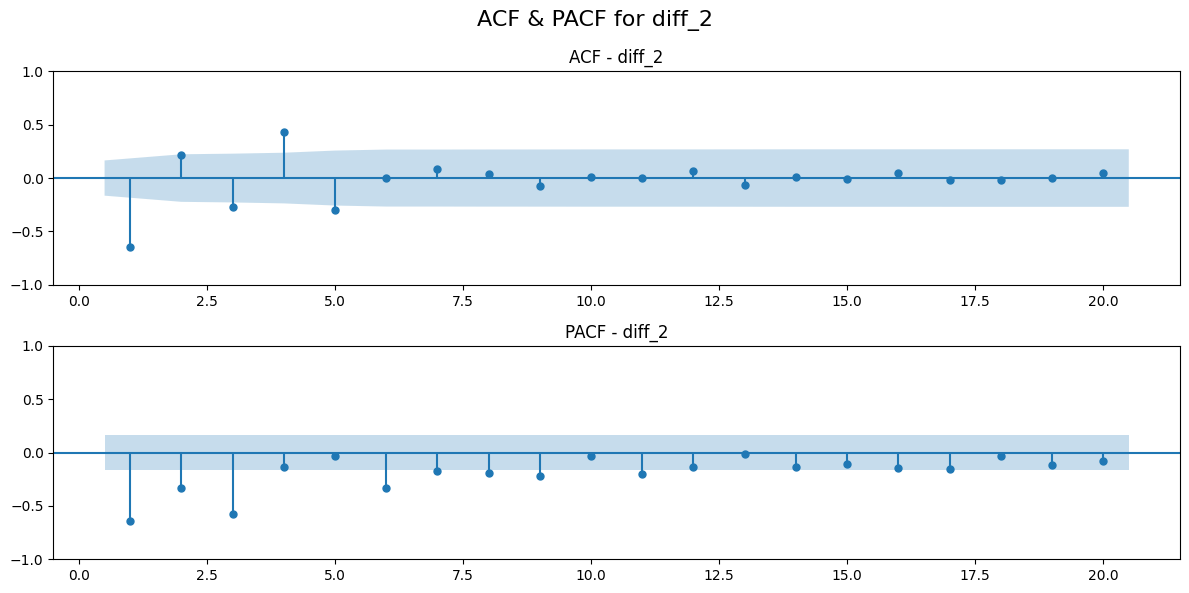

Plotting ACF & PACF for diff_3


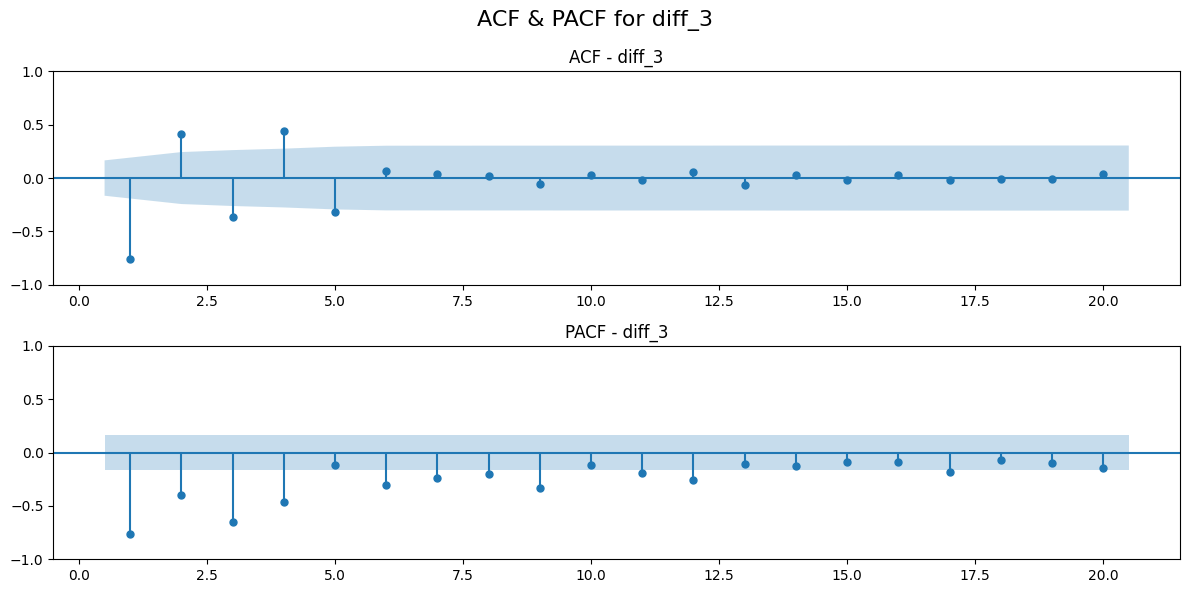

Plotting ACF & PACF for seasonsal_diff_1


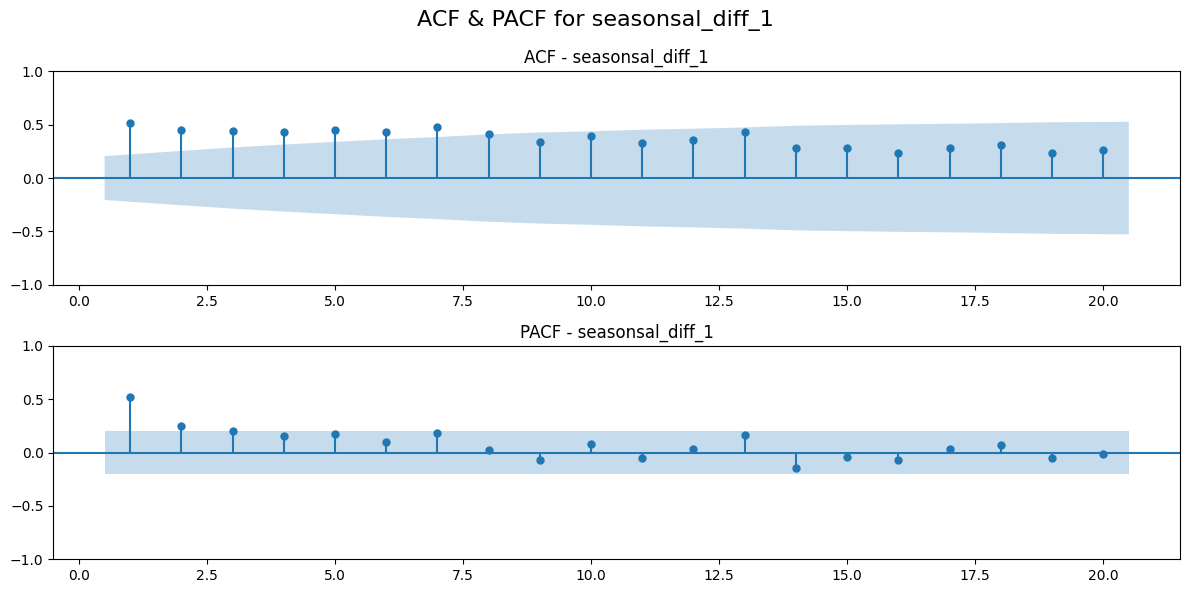

In [ ]:
store = '2'
store_df = df[df['store'] == store].sort_values('date').copy()

# Set the 'date' column as the index for easier time series manipulation.
store_df = store_df.set_index('date')
sales = store_df['weekly_sales']

# Create a dictionary to store our differenced series.
series_dict = {}

# 1. Original series (no differencing)
series_dict['original'] = sales

# 2. 1 week regular differenced series (first difference)
series_dict['diff_1'] = sales.diff().dropna()

# 3. 2 times regular differenced series (second difference)
series_dict['diff_2'] = sales.diff().diff().dropna()

# 4. 3 times regular differenced series (third difference)
series_dict['diff_3'] = sales.diff().diff().diff().dropna()

# 5. 52-week seasonal differenced series.
series_dict['seasonsal_diff_1'] = sales.diff(52).dropna()

# Function to plot ACF and PACF for each series.
def plot_differenced_series(series_dict, lags=20):
    for label, series in series_dict.items():
        fig, axes = plt.subplots(2, 1, figsize=(12, 6))
        fig.suptitle(f"ACF & PACF for {label}", fontsize=16)

        print(f"Plotting ACF & PACF for {label}")

        # Plot ACF
        plot_acf(series, ax=axes[0], lags=lags, zero=False)
        axes[0].set_title(f"ACF - {label}")

        # Plot PACF
        plot_pacf(series, ax=axes[1], lags=lags, method='ywm', zero=False)
        axes[1].set_title(f"PACF - {label}")

        plt.tight_layout()
        plt.show()

# Plot ACF and PACF for all our series.
plot_differenced_series(series_dict)


## Extra EDA To Do

1. Basic EDA
   - Agg sales time series plot
1. Holiday Flags:
   - Check for sales 2 weeks before and after holiday flags.
   - Do all holiday flags give boost to sales?
   - Quantify which flags are driving most and least sales.
   - Does a particular holiday flag have a stronger effect on sales of few stores than others? check relative sales growth in +- 2 weeks of that holiday for all stores. Do this for all holiday flags and also other dates that drive sales but aren't marked as holiday flags
   - Use Darts libary's anamoly detector to extract actual 'holidays' events that boost sales.
2. Seasonal Trends:
   - Check if you can smooth out the seasons even more (since we only have ~3 years of data, catching seasonal patterns might be hard). Try out different seasonal periods. USe Fourier Decomposition maybe?


**Forecasting**


# Forecasting

## ToDo
1. Use Darts libary's anamoly detector + forecaster to incorporate actual 'holidays' events that boost sales in forecasting.
2. Analysze residuals. Check the Ljung-Box test for residuals.
3. Add another loss metric too?
4. Use SHAP to analyse models post training.
5. Create results_dict as json convertible object and save it to a file.

### Different models

1. Holt Winters i.e. Triple Exponential Smoothing 

2. ARIMA with orders
    - (6, 1, 4)
    - (6, 1, 5)
    - (6, 2, 4)
    - (6, 2, 5)
    - (9, 2, 4)
    - (9, 2, 5)

3. SARIMA with orders
    - (6, 1, 4), (2, 1, 5, 52)
    - (6, 1, 5), (2, 1, 5, 52)
    - (6, 2, 4), (2, 1, 5, 52)
    - (6, 2, 5), (2, 1, 5, 52)
    - (9, 2, 4), (2, 1, 5, 52)
    - (9, 2, 5), (2, 1, 5, 52)

4. SARIMAX with cpi, holiday_flag and orders
    - (6, 1, 4), (2, 1, 5, 52)
    - (6, 1, 5), (2, 1, 5, 52)
    - (6, 2, 4), (2, 1, 5, 52)
    - (6, 2, 5), (2, 1, 5, 52)
    - (9, 2, 4), (2, 1, 5, 52)
    - (9, 2, 5), (2, 1, 5, 52)

5. XGBoost with
    - month
    - year
    - holiday_flag
    - CPI
    - lagged sales

6. FB Prophet

## Train, Test and Eval split

In [179]:
# Get sorted unique dates
unique_dates = sorted(df['date'].unique())
total_weeks = len(unique_dates)

# Reserve final 12 weeks for hold-out (final forecast)
holdout_dates = unique_dates[-12:]

# The remaining weeks (training + validation): should be total_weeks - 12.
train_val_dates = unique_dates[:-12]

# Split the 131 weeks: the first 105 weeks for training and the next 26 weeks for validation
train_dates = train_val_dates[:105]
val_dates = train_val_dates[105:]

## Loss metric

In [180]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))


## Data Preparation

In [181]:
# Get the unique store identifiers (assuming 'store' is categorical)
stores = df['store'].cat.categories.tolist()

# Create a results dictionary to store individual store results, and later aggregated metrics
results_dict = {}
results_dict['HoltWinters'] = {"store_results": {}, "aggregated_metrics": {}}

# We will forecast in 2-week horizons over the 26 validation weeks.
forecast_horizon = 1
n_forecast_iterations = len(val_dates) // forecast_horizon  # should be 26/2 = 13

## Model Training

### Holt Winters 

#### Training

In [151]:


# Loop over each store
for store in stores:
    # Filter the store’s data and sort it by date.
    store_df = df[df['store'] == store].sort_values('date').reset_index(drop=True)
    
    # Split the store data into training and validation sets based on date.
    train_store_df = store_df[store_df['date'].isin(train_dates)]
    valid_store_df = store_df[store_df['date'].isin(val_dates)]
    
    # Extract the weekly sales series (using 'date' as index)
    train_series = train_store_df.set_index('date')['weekly_sales']
    
    # Initialize lists to collect forecasts and actual values as we do a growing-window forecast.
    store_predictions = []
    store_actuals = []
    forecast_dates_list = []
    
    # Start with the training series; as we move forward, this will grow.
    series_gw = train_series.copy()
    
    # Iterate over each 2-week forecast window
    for i in range(n_forecast_iterations):
        # Fit the Holt–Winters (triple exponential smoothing) model:
        # We assume an additive trend and additive seasonal component with season_length 52.
        model = ExponentialSmoothing(
            series_gw,
            trend="add",
            seasonal="add",
            seasonal_periods=52,
            initialization_method="estimated",
            # use_boxcox=True
        )
        fit = model.fit(optimized=True, remove_bias=True, use_brute=True)
        
        # Forecast the next 'forecast_horizon' weeks
        forecast = fit.forecast(forecast_horizon)
        
        # Determine the forecast dates from our validation dates.
        # For each iteration, select the next 2 weeks in order.
        fc_start = i * forecast_horizon
        fc_end = (i + 1) * forecast_horizon
        fc_dates = val_dates[fc_start:fc_end]
        
        # Get the actual weekly sales for the forecast dates from the validation set.
        valid_series = valid_store_df.set_index('date')['weekly_sales']
        actual = valid_series.loc[fc_dates]
        
        # Append these forecasts and actuals to our lists.
        store_predictions.extend(forecast.values)
        store_actuals.extend(actual.values)
        forecast_dates_list.extend(fc_dates)
        
        # Update the growing window: as if we received these observations.
        # (Using pd.concat instead of .append to avoid deprecation warnings.)
        series_gw = pd.concat([series_gw, actual]).sort_index()
    
    # After finishing the growing window forecast, compute rmse for the store.
    store_predictions = np.array(store_predictions)
    store_actuals = np.array(store_actuals)
    store_rmse = rmse(store_actuals, store_predictions)
    
    # Save results for this store.
    results_dict['HoltWinters']['store_results'][store] = {
        'forecast_dates': forecast_dates_list,
        'predictions': store_predictions,
        'actuals': store_actuals,
        'rmse': store_rmse
    }

c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-FRI will be used.

c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-FRI will be used.

c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:47

#### Calculate Errors

In [152]:
all_rmse = []
for store in stores:
    store_rmse = results_dict['HoltWinters']['store_results'][store]['rmse']
    all_rmse.append(store_rmse)

avg_rmse = np.mean(all_rmse)
std_rmse = np.std(all_rmse)

results_dict['HoltWinters']['aggregated_metrics'] = {
    'avg_rmse': avg_rmse,
    'std_rmse': std_rmse
}

print("Holt Winters Aggregated RMSE across stores:")
print("Average RMSE:", avg_rmse)
print("Std of RMSE:", std_rmse)

Holt Winters Aggregated RMSE across stores:
Average RMSE: 58874.64921348473
Std of RMSE: 38530.58176058082


#### Visualize predictions

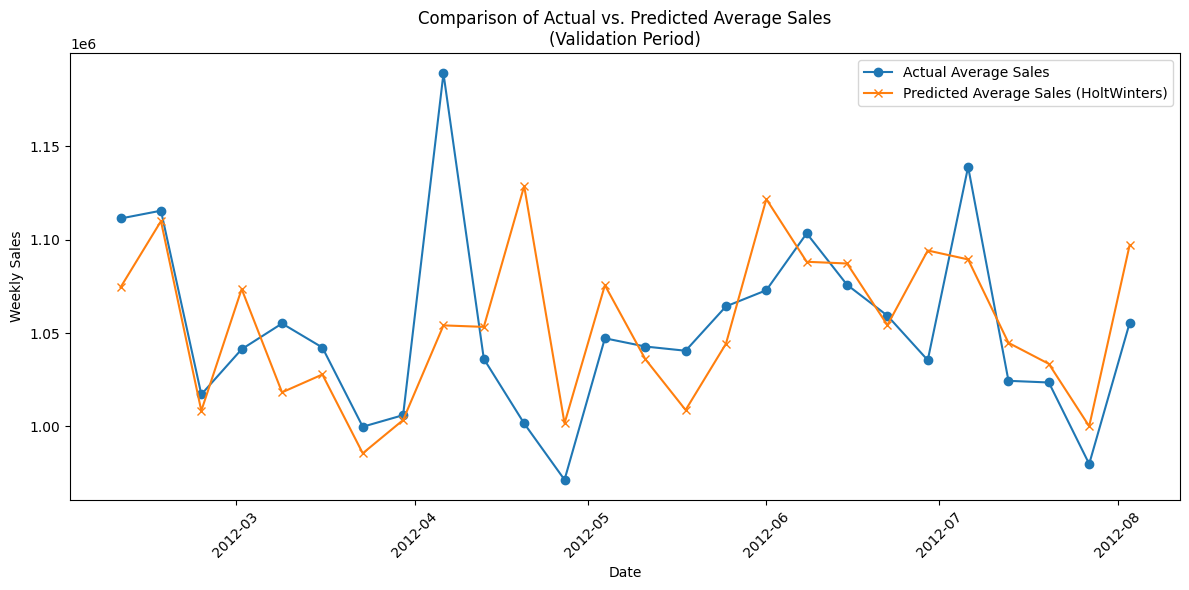

In [153]:
# Initialize dictionaries to aggregate forecast values by date.
pred_by_date = defaultdict(list)
actual_by_date = defaultdict(list)

# Loop through each store's results
for store in stores:
    store_result = results_dict['HoltWinters']['store_results'][store]
    for dt, pred, actual in zip(store_result['forecast_dates'],
                                  store_result['predictions'],
                                  store_result['actuals']):
        # Convert dt into a pd.Timestamp (if not already)
        dt = pd.to_datetime(dt)
        pred_by_date[dt].append(pred)
        actual_by_date[dt].append(actual)

# Sort the forecasted dates
sorted_dates = sorted(pred_by_date.keys())

# For each date, compute the average predicted and actual weekly sales.
avg_pred = [np.mean(pred_by_date[dt]) for dt in sorted_dates]
avg_actual = [np.mean(actual_by_date[dt]) for dt in sorted_dates]

# Plot the actual vs. predicted average sales
plt.figure(figsize=(12, 6))
plt.plot(sorted_dates, avg_actual, marker='o', label='Actual Average Sales')
plt.plot(sorted_dates, avg_pred, marker='x',
         label='Predicted Average Sales (HoltWinters)')
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.title("Comparison of Actual vs. Predicted Average Sales\n(Validation Period)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### ARIMA

#### Training

In [182]:
# Define candidate ARIMA orders to consider
candidate_orders = [(6, 1, 4), (6, 1, 5), (6, 2, 4), (6, 2, 5)]

# Initialize space in results_dict for ARIMA results
results_dict['ARIMA'] = {"store_results": {}, "aggregated_metrics": {}}

# Get unique stores (assuming the store column is categorical)
stores = df['store'].cat.categories.tolist()

# Loop over each store
for store in stores:
    # Filter the store’s data and sort by date
    store_df = df[df['store'] == store].sort_values('date').reset_index(drop=True)
    
    # Split the data into training and validation based on date.
    train_store_df = store_df[store_df['date'].isin(train_dates)]
    valid_store_df = store_df[store_df['date'].isin(val_dates)]
    
    # Extract the weekly sales series from training data.
    train_series = train_store_df.set_index('date')['weekly_sales']
    
    # First, determine the best ARIMA order by fitting each candidate on just the
    # training portion (105 weeks) and comparing their AIC.
    best_aic = np.inf
    best_order = None
    aic_bic = pd.DataFrame(columns=['order', 'aic', 'bic'], index = list(range(len(candidate_orders)))) 
    for idx, order in enumerate(candidate_orders):
        try:
            # Suppress warnings during the ARIMA fitting
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                model = ARIMA(train_series, order=order)
                fit_model = model.fit()
                aic_bic.iloc[idx]['order'] = order
                aic_bic.iloc[idx]['aic'] = fit_model.aic
                aic_bic.iloc[idx]['bic'] = fit_model.bic
                # print(f"For store {store}, order {order}, AIC: {fit_model.aic}, BIC: {fit_model.bic}")
            if fit_model.aic < best_aic:
                best_aic = fit_model.aic
                best_order = order
        except Exception as e:
            print(f"Store {store}, order {order} failed: {e}")
            continue

    print(f"Store {store} -- Selected ARIMA order: {best_order} (AIC: {best_aic}) (BIC: {fit_model.bic})")
    
    # Now, using the selected best_order, do a growing-window forecast on the
    # 26-week validation set (forecasting 2 weeks at a time).
    store_predictions = []
    store_actuals = []
    forecast_dates_list = []
    
    # Start the growing window with the training series.
    series_gw = train_series.copy()
    
    # The number of forecast iterations (26 weeks / 2 per iteration).
    n_forecast_iterations = len(val_dates) // forecast_horizon
    
    for i in range(n_forecast_iterations):
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                model_gw = ARIMA(series_gw, order=best_order)
                fit_gw = model_gw.fit()
            forecast_result = fit_gw.forecast(steps=forecast_horizon)
        except Exception as e:
            print(f"Store {store}: Forecast iteration {i} failed with error: {e}")
            # If forecasting fails, you can choose to assign missing values.
            forecast_result = np.full(forecast_horizon, np.nan)
    
        # Identify the forecast dates (next 2 weeks from the validation list)
        fc_start = i * forecast_horizon
        fc_end = (i + 1) * forecast_horizon
        fc_dates = val_dates[fc_start:fc_end]
        
        # Get the actual values for these forecast dates
        valid_series = valid_store_df.set_index('date')['weekly_sales']
        actual = valid_series.loc[fc_dates]
    
        # Append predictions, actuals, and forecast dates
        store_predictions.extend(
            forecast_result if isinstance(forecast_result, np.ndarray)
            else forecast_result.tolist()
        )
        store_actuals.extend(actual.values)
        forecast_dates_list.extend(fc_dates)
    
        # Grow the training window with the actual observations just forecasted.
        series_gw = pd.concat([series_gw, actual]).sort_index()
    
    # Compute rmse for the store based on the growing window forecasts
    store_predictions = np.array(store_predictions)
    store_actuals = np.array(store_actuals)
    store_rmse = rmse(store_actuals, store_predictions)
    
    # Save the results for this store in results_dict
    results_dict['ARIMA']['store_results'][store] = {
        'best_order': best_order,
        'forecast_dates': forecast_dates_list,
        'predictions': store_predictions,
        'actuals': store_actuals,
        'rmse': store_rmse
    }

Store 1 -- Selected ARIMA order: (6, 1, 4) (AIC: 2818.0780648587734) (BIC: 2867.8032434909373)
Store 10 -- Selected ARIMA order: (6, 2, 4) (AIC: 2936.7706540487275) (BIC: 2970.7334521002676)
Store 11 -- Selected ARIMA order: (6, 1, 5) (AIC: 2818.2951002710333) (BIC: 2859.357184555432)
Store 12 -- Selected ARIMA order: (6, 1, 4) (AIC: 2784.594169993079) (BIC: 2826.0934982129324)
Store 13 -- Selected ARIMA order: (6, 2, 4) (AIC: 2920.7060725956435) (BIC: 2955.0601067873613)
Store 14 -- Selected ARIMA order: (6, 1, 5) (AIC: 2930.240327463138) (BIC: 2970.464970007862)
Store 15 -- Selected ARIMA order: (6, 1, 4) (AIC: 2749.2833027404986) (BIC: 2782.68241567147)
Store 16 -- Selected ARIMA order: (6, 2, 4) (AIC: 2652.273495741868) (BIC: 2684.316875653312)
Store 17 -- Selected ARIMA order: (6, 1, 4) (AIC: 2740.223806509719) (BIC: 2784.680324890462)
Store 18 -- Selected ARIMA order: (6, 1, 4) (AIC: 2828.9544456785757) (BIC: 2863.708195402188)
Store 19 -- Selected ARIMA order: (6, 1, 5) (AIC: 28

#### Calculate Errors

In [185]:
# Aggregate error metrics (across all stores)
all_rmse = []
for store in stores:
    store_rmse = results_dict['ARIMA']['store_results'][store]['rmse']
    all_rmse.append(store_rmse)
    if pd.isnull(store_rmse):
        print("Store:", store, "has no RMSE")

avg_rmse = np.mean(all_rmse, where=~np.isnan(all_rmse))
std_rmse = np.std(all_rmse, where=~np.isnan(all_rmse))

results_dict['ARIMA']['aggregated_metrics'] = {
    'avg_rmse': avg_rmse,
    'std_rmse': std_rmse
}

pd.Series(all_rmse).describe()

Store: 38 has no RMSE


count        44.000000
mean      73483.575356
std       41815.577837
min       11108.056022
25%       43897.261231
50%       65114.565923
75%      113117.467519
max      167100.140862
dtype: float64

#### Visualize Predictions

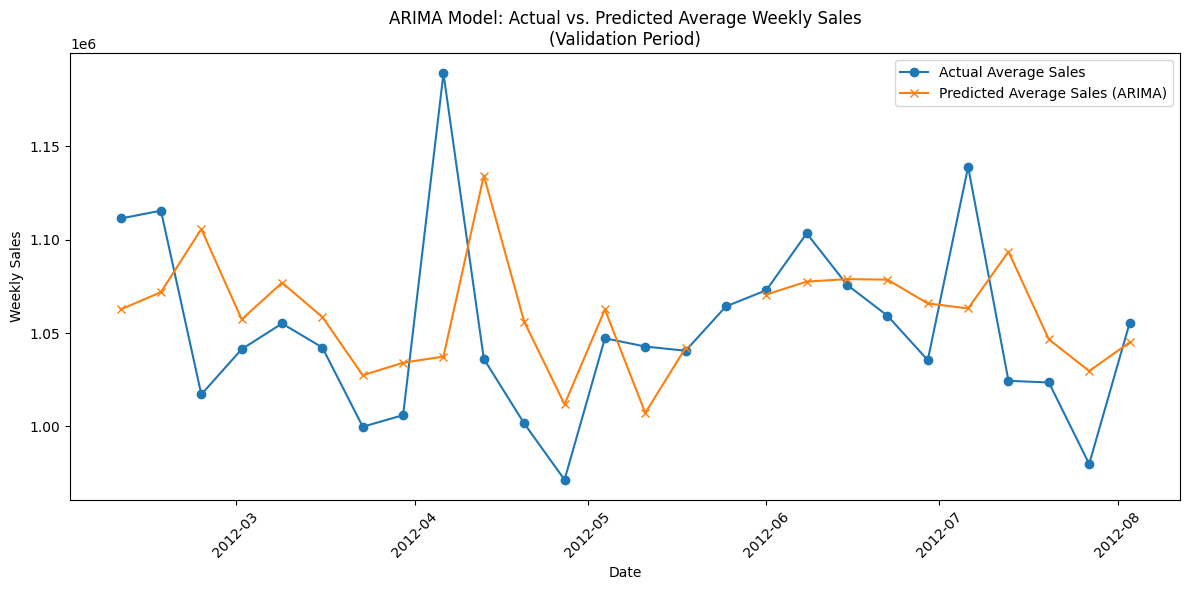

In [186]:
# We'll collect forecasted predictions and actuals per date across all stores.
pred_by_date = defaultdict(list)
actual_by_date = defaultdict(list)

for store in stores:
    store_result = results_dict['ARIMA']['store_results'][store]
    for dt, pred, act in zip(store_result['forecast_dates'],
                             store_result['predictions'],
                             store_result['actuals']):
        dt = pd.to_datetime(dt)
        pred_by_date[dt].append(pred)
        actual_by_date[dt].append(act)

# Sort the forecasted dates
sorted_dates = sorted(pred_by_date.keys())

# Calculate the average predicted and actual sales across stores for each date.
avg_pred = [np.mean(pred_by_date[dt]) for dt in sorted_dates]
avg_actual = [np.mean(actual_by_date[dt]) for dt in sorted_dates]

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(sorted_dates, avg_actual, marker='o', label='Actual Average Sales')
plt.plot(sorted_dates, avg_pred, marker='x',
         label='Predicted Average Sales (ARIMA)')
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.title("ARIMA Model: Actual vs. Predicted Average Weekly Sales\n(Validation Period)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### SARIMA

#### Separate train test split and growing windows

In [ ]:
# Split the 131 weeks: the first 111 weeks for training and the next 20 weeks for validation
train_dates = train_val_dates[:105]
val_dates = train_val_dates[105:]

# We will forecast in 4-week horizons over the 20 validation weeks.
forecast_horizon = 1
n_forecast_iterations = len(val_dates) // forecast_horizon  # should be 20/2 = 10

random_stores = random.sample(stores, 25)

#### Training

In [ ]:
# Define candidate non-seasonal orders for SARIMA
candidate_orders = [(6, 1, 4)] # , (6, 1, 5), (6, 2, 4), (6, 2, 5)
# Fixed seasonal order: (P, D, Q, m)
seasonal_order = (2, 1, 5, 52)

# Initialize space in the results dictionary for SARIMA
results_dict['SARIMA'] = {"store_results": {}, "aggregated_metrics": {}}

# Loop over each store
for store in random_stores:
    # Filter the store’s data and sort by date
    store_df = df[df['store'] == store].sort_values('date').reset_index(drop=True)
    
    # Split the store data into training and validation based on date
    train_store_df = store_df[store_df['date'].isin(train_dates)]
    valid_store_df = store_df[store_df['date'].isin(val_dates)]
    
    # Convert training data into a time series with date as index
    train_series = train_store_df.set_index('date')['weekly_sales']
    
    # -----------------------------------------------------
    # Step 1: Model Selection -- Choose Best Non-Seasonal Order
    # -----------------------------------------------------
    best_aic = np.inf
    best_order = None
    # aic_bic = pd.DataFrame(columns=['order', 'aic', 'bic'], index = list(range(len(candidate_orders)))) 
    for order in candidate_orders:
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                model = SARIMAX(train_series,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
                fit_model = model.fit(disp=False)
                # aic_bic.iloc[idx]['order'] = order
                # aic_bic.iloc[idx]['aic'] = fit_model.aic
                # aic_bic.iloc[idx]['bic'] = fit_model.bic
                # print(f"For store {store}, order {order}, AIC: {fit_model.aic}, BIC: {fit_model.bic}")
            # if fit_model.aic < best_aic:
            #     best_aic = fit_model.aic
                best_order = order
        except Exception as e:
            print(f"Store {store}, SARIMA candidate order {order} failed: {e}")
            continue

    print(f"Store {store} -- Selected SARIMA order: {best_order}, "
          f"Seasonal: {seasonal_order} (AIC: {fit_model.aic}) (BIC: {fit_model.bic})")
    
    # -----------------------------------------------------
    # Step 2: Growing-Window Forecast with Selected SARIMA Order
    # -----------------------------------------------------
    store_predictions = []
    store_actuals = []
    forecast_dates_list = []
    
    # Start with the training series as the initial window
    series_gw = train_series.copy()
    
    # Number of forecast iterations (26 weeks / forecast_horizon weeks per forecast)
    n_forecast_iterations = len(val_dates) // forecast_horizon
    
    for i in range(n_forecast_iterations):
        print(f"Forecast iteration {i+1} of {n_forecast_iterations}")
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                model_gw = SARIMAX(series_gw,
                                   order=best_order,
                                   seasonal_order=seasonal_order,
                                   enforce_stationarity=False,
                                   enforce_invertibility=False)
                fit_gw = model_gw.fit(disp=False)
                forecast_result = fit_gw.forecast(steps=forecast_horizon)
        except Exception as e:
            print(f"Store {store}: Forecast iteration {i} failed: {e}")
            forecast_result = np.full(forecast_horizon, np.nan)
    
        # Identify forecast dates (next 2 weeks from validation dates)
        fc_start = i * forecast_horizon
        fc_end = (i + 1) * forecast_horizon
        fc_dates = val_dates[fc_start:fc_end]
    
        # Get the actual values from the validation set for these dates
        valid_series = valid_store_df.set_index('date')['weekly_sales']
        actual = valid_series.loc[fc_dates]
    
        # Append forecasts, actual values, and dates
        store_predictions.extend(
            forecast_result if isinstance(forecast_result, np.ndarray)
            else forecast_result.tolist()
        )
        store_actuals.extend(actual.values)
        forecast_dates_list.extend(fc_dates)
    
        # Update the growing window with the actual values (simulate receiving new data)
        series_gw = pd.concat([series_gw, actual]).sort_index()
    
    # Compute store-level rmse for SARIMA forecasts
    store_predictions = np.array(store_predictions)
    store_actuals = np.array(store_actuals)
    store_rmse = rmse(store_actuals, store_predictions)
    
    # Save store results in the results dictionary
    results_dict['SARIMA']['store_results'][store] = {
        'best_order': best_order,
        'seasonal_order': seasonal_order,
        'forecast_dates': forecast_dates_list,
        'predictions': store_predictions,
        'actuals': store_actuals,
        'rmse': store_rmse
    }

c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 6 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 38 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 1 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 22 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 16 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 2 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 31 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 44 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 39 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 35 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 23 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 12 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 17 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 8 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 24 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 13 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 7 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 33 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 18 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 29 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 30 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 42 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 4 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 45 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 20 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


#### Calculate Errors

In [ ]:
all_rmse = []
for store in random_stores:
    store_rmse = results_dict['SARIMA']['store_results'][store]['rmse']
    all_rmse.append(store_rmse)
    if pd.isnull(store_rmse):
        print(f'Store {store} has no rmse')

avg_rmse = np.mean(all_rmse)
std_rmse = np.std(all_rmse)

results_dict['SARIMA']['aggregated_metrics'] = {
    'avg_rmse': avg_rmse,
    'std_rmse': std_rmse
}

pd.Series(all_rmse).describe()

count    25.000000
mean      0.111026
std       0.076609
min       0.030905
25%       0.062593
50%       0.088156
75%       0.132114
max       0.345813
dtype: float64

#### Visualize Predictions

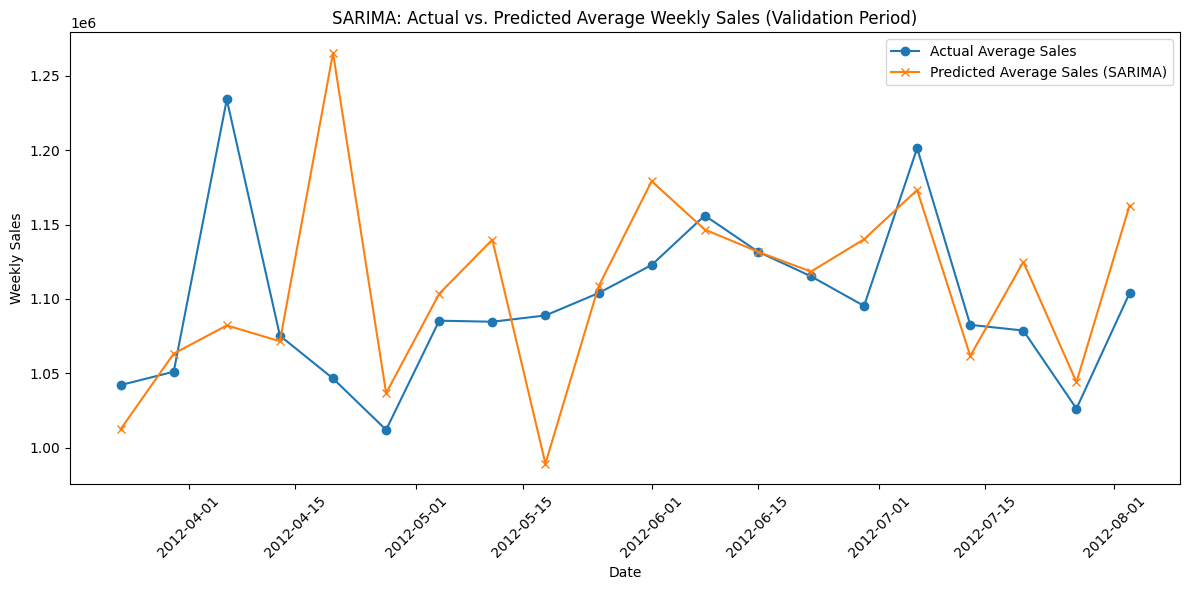

In [104]:
# Aggregate predicted and actual sales by forecast date (across stores).
pred_by_date = defaultdict(list)
actual_by_date = defaultdict(list)

for store in random_stores:
    store_result = results_dict['SARIMA']['store_results'][store]
    for dt, pred, act in zip(store_result['forecast_dates'],
                             store_result['predictions'],
                             store_result['actuals']):
        dt = pd.to_datetime(dt)
        pred_by_date[dt].append(pred)
        actual_by_date[dt].append(act)

# Sort forecast dates
sorted_dates = sorted(pred_by_date.keys())

# Compute the average prediction and actual value for each date
avg_pred = [np.mean(pred_by_date[dt]) for dt in sorted_dates]
avg_actual = [np.mean(actual_by_date[dt]) for dt in sorted_dates]

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(sorted_dates, avg_actual, marker='o', label='Actual Average Sales')
plt.plot(sorted_dates, avg_pred, marker='x', label='Predicted Average Sales (SARIMA)')
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.title("SARIMA: Actual vs. Predicted Average Weekly Sales (Validation Period)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### XGBoost

#### Separate train test split and growing windows

In [187]:
# Split the 131 weeks: the first 105 weeks for training and the next 26 weeks for validation
train_dates = train_val_dates[:105]
val_dates = train_val_dates[105:]

# We will forecast in 4-week horizons over the 20 validation weeks.
forecast_horizon = 1
n_forecast_iterations = len(val_dates) // forecast_horizon  # should be 20/2 = 10

# random_stores = random.sample(stores, 25)


#### Training

In [188]:
def create_features(df, lags=[1, 2], include_diffs=True):
    df = df.copy()
    df["month"] = df["date"].dt.month
    df["year"] = df["date"].dt.year
    df["holiday_flag_int"] = df["holiday_flag"].astype(int)
    
    # Create lag features
    for lag in lags:
        df[f"sales_lag_{lag}"] = df["weekly_sales"].shift(periods = lag)
    
    # Create difference features if required.
    if include_diffs:
        # First-order difference: difference between consecutive weekly_sales
        df["sales_diff_1"] = df["weekly_sales"].diff(1)
        # Second-order difference: difference of first differences (or equivalently
        # the two-period difference)
        df["sales_diff_2"] = df["weekly_sales"].diff(2)
    
    # Drop rows with missing values due to lag / difference calculation.
    df = df.dropna()
    return df

In [189]:
results_dict["XGBoost"] = {"store_results": {}, "aggregated_metrics": {}}

# Assume stores are available from the categorical 'store' column.
stores = df["store"].cat.categories.tolist()

# Define lag values. (These are used in addition to our newly added difference features.)
lag_features = [1, 2, 3, 4, 5, 6]

for store in stores:
    # Filter and sort the data for the current store.
    store_df = df[df["store"] == store].sort_values("date").reset_index(drop=True)

    # Split the store's data into training (105 weeks) and validation (26 weeks).
    train_store_df = store_df[store_df["date"].isin(train_dates)]
    valid_store_df = store_df[store_df["date"].isin(val_dates)]
    
    # Start the growing window with the training data.
    data_gw = train_store_df.copy()
    data_gw = data_gw.sort_values("date").reset_index(drop=True)
    
    # Lists to hold forecasts/actuals for the current store.
    store_predictions = []
    store_actuals = []
    forecast_dates_list = []
    
    # Calculate the number of iterations based on the forecast horizon.
    n_iter = len(val_dates) // forecast_horizon
    
    for i in range(n_iter):
        # --- TRAINING STEP ---
        # Build the training features using the helper function (includes diffs).
        train_feats = create_features(data_gw, lags=lag_features, include_diffs=True)
        
        # Define the feature set.
        # Calendar features, holiday_flag, CPI, lags, and differences.
        X_train = train_feats[[
            "month",
            "year",
            "holiday_flag_int",
            "cpi",
            "sales_lag_1",
            "sales_lag_2",
            "sales_lag_3",
            "sales_lag_4",
            "sales_lag_5",
            "sales_lag_6",
            "sales_diff_1",
            "sales_diff_2"
        ]]
        y_train = train_feats["weekly_sales"]
        
        # Train the XGBoost model. Adjust hyperparameters as needed.
        model = xgb.XGBRegressor(
            objective="reg:squarederror",
            n_estimators=50,
            max_depth=5,
            learning_rate=0.075,
            random_state=42,
        )
        model.fit(X_train, y_train)
        
        # --- FORECASTING STEP ---
        # Determine forecast dates for the current window (next 2 weeks).
        fc_start = i * forecast_horizon
        fc_end = (i + 1) * forecast_horizon
        fc_dates = val_dates[fc_start:fc_end]
        
        fc_preds = []
        for fc_date in fc_dates:
            # Extract calendar and economic features from the validation set.
            row = valid_store_df[valid_store_df["date"] == fc_date]
            if row.empty:
                continue
            month = row["date"].dt.month.values[0]
            year = row["date"].dt.year.values[0]
            holiday_flag_int = int(row["holiday_flag"].values[0])
            CPI_val = row["cpi"].values[0]
            
            # --- Compute lag features from data_gw ---
            # Ensure we have enough observations to compute both lag and difference features.
            sales_lag_1 = data_gw["weekly_sales"].iloc[-1]
            sales_lag_2 = data_gw["weekly_sales"].iloc[-2] #if len(data_gw) >= 2 else sales_lag_1
            sales_lag_3 = data_gw["weekly_sales"].iloc[-3]
            sales_lag_4 = data_gw["weekly_sales"].iloc[-4] #if len(data_gw) >= 2 else sales_lag_1
            sales_lag_5 = data_gw["weekly_sales"].iloc[-3]
            sales_lag_6 = data_gw["weekly_sales"].iloc[-4] #if len(data_gw) >= 2 else sales_lag_1
            
            # Compute first difference feature
            sales_diff_1 = sales_lag_1 - sales_lag_2
            
            # For the second difference, we need the third most recent data point.
            if len(data_gw) >= 3:
                # sales_lag_3 = data_gw["weekly_sales"].iloc[-3]
                sales_diff_2 = sales_lag_1 - 2 * sales_lag_2 + sales_lag_3
            else:
                sales_diff_2 = sales_diff_1  # Fallback if not enough data
            
            # Construct a DataFrame for this forecast sample.
            X_fc = pd.DataFrame({
                "month": [month],
                "year": [year],
                "holiday_flag_int": [holiday_flag_int],
                "cpi": [CPI_val],
                "sales_lag_1": [sales_lag_1],
                "sales_lag_2": [sales_lag_2],
                "sales_lag_3": [sales_lag_3],
                "sales_lag_4": [sales_lag_4],
                "sales_lag_5": [sales_lag_5],
                "sales_lag_6": [sales_lag_6],
                "sales_diff_1": [sales_diff_1],
                "sales_diff_2": [sales_diff_2],
            })
            
            # Generate the prediction for the current forecast date.
            pred = model.predict(X_fc)[0]
            fc_preds.append(pred)
            
            # Append the predicted record to the growing window data.
            # Some features (e.g., temperature/fuel_price/unemployment) may not be available.
            new_row = pd.DataFrame({
                "store": [store],
                "date": [fc_date],
                "weekly_sales": [row["weekly_sales"].values[0]],
                "holiday_flag": [row["holiday_flag"].values[0]],
                "temperature": [np.nan],
                "fuel_price": [np.nan],
                "cpi": [CPI_val],
                "unemployment": [np.nan],
            })
            data_gw = pd.concat([data_gw, new_row], ignore_index=True)
            data_gw = data_gw.sort_values("date").reset_index(drop=True)
        
        # Get actual weekly_sales for these forecast dates.
        actual_vals = []
        for fc_date in fc_dates:
            act_row = valid_store_df[valid_store_df["date"] == fc_date]
            if act_row.empty:
                continue
            actual_vals.append(act_row["weekly_sales"].values[0])
        
        store_predictions.extend(fc_preds)
        store_actuals.extend(actual_vals)
        forecast_dates_list.extend(fc_dates)
    
    # Compute rmse for this store.
    store_rmse = rmse(np.array(store_actuals), np.array(store_predictions))
    
    # Save store results in the results dictionary.
    results_dict["XGBoost"]["store_results"][store] = {
        "forecast_dates": forecast_dates_list,
        "predictions": np.array(store_predictions),
        "actuals": np.array(store_actuals),
        "rmse": store_rmse,
    }


#### Calculate Errors

In [190]:
all_rmse = []
for store in stores:
    all_rmse.append(results_dict["XGBoost"]["store_results"][store]["rmse"])
avg_rmse = np.mean(all_rmse)
std_rmse = np.std(all_rmse)

results_dict["XGBoost"]["aggregated_metrics"] = {
    "avg_rmse": avg_rmse,
    "std_rmse": std_rmse,
}

print("XGBoost Aggregated rmse across stores:")
print("Average rmse:", avg_rmse)
print("Standard Deviation of rmse:", std_rmse)

XGBoost Aggregated rmse across stores:
Average rmse: 93241.18785949251
Standard Deviation of rmse: 57405.855220578684


#### Visualize Predictions

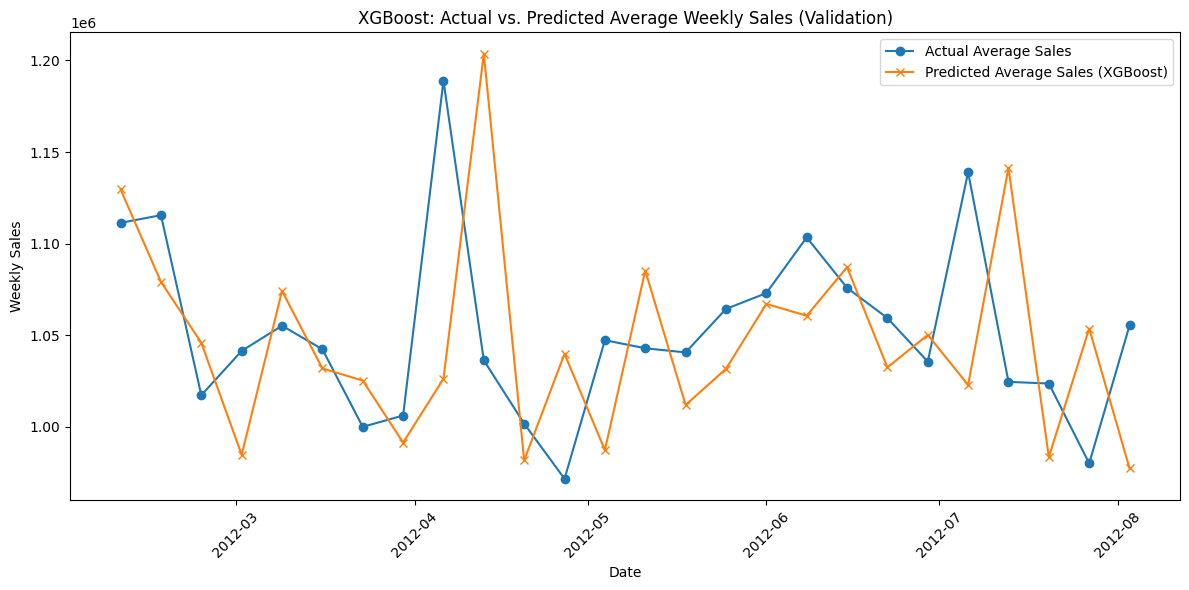

In [191]:
pred_by_date = defaultdict(list)
actual_by_date = defaultdict(list)

for store in stores:
    store_result = results_dict["XGBoost"]["store_results"][store]
    for dt, pred, act in zip(store_result["forecast_dates"],
                             store_result["predictions"],
                             store_result["actuals"]):
        dt = pd.to_datetime(dt)
        pred_by_date[dt].append(pred)
        actual_by_date[dt].append(act)

# Sort the forecast dates and compute the average across stores.
sorted_dates = sorted(pred_by_date.keys())
avg_pred = [np.mean(pred_by_date[dt]) for dt in sorted_dates]
avg_actual = [np.mean(actual_by_date[dt]) for dt in sorted_dates]

plt.figure(figsize=(12, 6))
plt.plot(sorted_dates, avg_actual, marker="o", label="Actual Average Sales")
plt.plot(sorted_dates, avg_pred, marker="x", label="Predicted Average Sales (XGBoost)")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.title("XGBoost: Actual vs. Predicted Average Weekly Sales (Validation)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### FB Prophet

#### Separate train test split and growing windows

In [174]:
# Split the 131 weeks: the first 105 weeks for training and the next 26 weeks for validation
train_dates = train_val_dates[:105]
val_dates = train_val_dates[105:]

# We will forecast in 4-week horizons over the 20 validation weeks.
forecast_horizon = 1
n_forecast_iterations = len(val_dates) // forecast_horizon  # should be 20/2 = 10

# random_stores = random.sample(stores, 25)


#### Training

In [175]:
import logging

logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

In [176]:
# Initialize results dictionary for Prophet forecasts.
results_dict["Prophet"] = {"store_results": {}, "aggregated_metrics": {}}

# Get the list of stores (assuming the store column is categorical).
stores = df["store"].cat.categories.tolist()

holidays = (
    df[df['holiday_flag']][['date']]  # select only rows where holiday_flag is True
    .drop_duplicates()               # remove duplicate dates if needed
    .rename(columns={'date': 'ds'})
)
holidays['holiday'] = 'holiday'  # Label each date with a name (could be more specific)
# Optionally, if you believe the effect spans extra days, add a window:
holidays['lower_window'] = -1  # The holiday's effect starts one day prior
holidays['upper_window'] = 1   # The effect lasts one day after

# Loop over each store.
for store in stores:
    # --- Data Preparation for Prophet ---
    # Filter the data for the current store and sort by date.
    store_df = df[df["store"] == store].sort_values("date").reset_index(drop=True)
    
    # Split store_df into training and validation based on your date lists.
    train_store_df = store_df[store_df["date"].isin(train_dates)]
    valid_store_df = store_df[store_df["date"].isin(val_dates)]
    
    # Convert to Prophet's expected format: "ds" (for date) and "y" (for weekly_sales).
    train_prophet = train_store_df[["date", "weekly_sales"]].rename(
        columns={"date": "ds", "weekly_sales": "y"}
    )
    valid_prophet = valid_store_df[["date", "weekly_sales"]].rename(
        columns={"date": "ds", "weekly_sales": "y"}
    )
    
    # Initialize lists to store forecasts, actuals, and the forecast dates.
    store_predictions = []
    store_actuals = []
    forecast_dates_list = []
    
    # Determine the number of forecast iterations (e.g., for 26 weeks with a 2-week horizon).
    n_iter = len(valid_prophet) // forecast_horizon
    valid_dates = valid_prophet["ds"].tolist()  # these should already be sorted
    
    # Growing-window forecast loop.
    for i in range(n_iter):
        # Initialize the Prophet model with appropriate parameters
        model = Prophet(
            growth="linear",                # Use a linear trend.
            changepoints=None,              # Let Prophet automatically pick changepoints.
            n_changepoints=25,              # Default number of potential changepoints.
            changepoint_range=0.8,            # Use the first 80% of the history for changepoint detection.
            yearly_seasonality=True,        # Include yearly seasonality (important for holidays).
            weekly_seasonality=False,        # Include weekly seasonality (even for weekly data, if relevant).
            daily_seasonality=False,        # Daily seasonality is not applicable for weekly data.
            holidays=holidays,              # Pass in your holidays DataFrame.
            seasonality_mode="additive",    # Use an additive seasonality.
            seasonality_prior_scale=10.0,   # Default prior scale for seasonal effects.
            holidays_prior_scale=10.0,      # Default prior scale for holiday effects.
            changepoint_prior_scale=0.05,   # Controls the flexibility of trend changepoints.
            mcmc_samples=0,                 # Use MAP estimation for faster fitting.
            interval_width=0.80,            # 80% prediction intervals.
            uncertainty_samples=1000,       # Number of draws for uncertainty estimation.
            stan_backend=None,              # Automatically select a Stan backend.
            holidays_mode='additive'        # Use additive holiday effects.
        )
        model.fit(train_prophet)
        
        # Determine the current forecast dates from the validation set.
        fc_start = i * forecast_horizon
        fc_end = (i + 1) * forecast_horizon
        fc_dates = valid_dates[fc_start:fc_end]
        
        # Create a "future" dataframe with the forecast dates.
        future = pd.DataFrame({"ds": fc_dates})
        forecast = model.predict(future)
        predictions = forecast["yhat"].values
        
        # Retrieve the actual observed sales for these fc_dates.
        actual_vals = valid_prophet[valid_prophet["ds"].isin(fc_dates)]["y"].values
        
        # Store predictions, actuals, and the associated dates.
        store_predictions.extend(predictions)
        store_actuals.extend(actual_vals)
        forecast_dates_list.extend(fc_dates)
        
        # IMPORTANT: Grow the training set with the ACTUAL observed values from the validation set.
        new_train = valid_prophet[valid_prophet["ds"].isin(fc_dates)]
        train_prophet = pd.concat([train_prophet, new_train]).sort_values("ds").reset_index(drop=True)
    
    # Compute the RMSE for the current store.
    store_rmse = rmse(np.array(store_actuals), np.array(store_predictions))

    print(f"Store: {store}, RMSE: {store_rmse}")
    
    # Save the store-specific results.
    results_dict["Prophet"]["store_results"][store] = {
        "forecast_dates": forecast_dates_list,
        "predictions": np.array(store_predictions),
        "actuals": np.array(store_actuals),
        "rmse": store_rmse,
    }


Store: 1, RMSE: 109453.42087280302
Store: 10, RMSE: 90310.93169744058
Store: 11, RMSE: 78822.75367009503
Store: 12, RMSE: 48109.74824184992
Store: 13, RMSE: 93681.86438999111
Store: 14, RMSE: 196933.9059604053
Store: 15, RMSE: 36736.79404710509
Store: 16, RMSE: 32100.561207943556
Store: 17, RMSE: 48932.74199100521
Store: 18, RMSE: 73699.67742298725
Store: 19, RMSE: 84821.4213153649
Store: 2, RMSE: 118138.26424885621
Store: 20, RMSE: 159783.04928618894
Store: 21, RMSE: 38921.85839887736
Store: 22, RMSE: 56143.175198336394
Store: 23, RMSE: 78979.16804099131
Store: 24, RMSE: 84545.73789684301
Store: 25, RMSE: 37523.7930658413
Store: 26, RMSE: 59702.48404277817
Store: 27, RMSE: 86838.58140146261
Store: 28, RMSE: 146042.75341677928
Store: 29, RMSE: 30753.605879096373
Store: 3, RMSE: 29656.571021971275
Store: 30, RMSE: 16883.238708798843
Store: 31, RMSE: 60225.02804044986
Store: 32, RMSE: 49133.59236091076
Store: 33, RMSE: 19541.02019571724
Store: 34, RMSE: 43898.188363125555
Store: 35, RMSE

#### Calculate Errors

In [177]:
all_rmse = [results_dict["Prophet"]["store_results"][store]["rmse"] for store in stores]
avg_rmse = np.mean(all_rmse)
std_rmse = np.std(all_rmse)

results_dict["Prophet"]["aggregated_metrics"] = {"avg_rmse": avg_rmse, "std_rmse": std_rmse}

print("Prophet Aggregated RMSE across stores:")
print("Average RMSE:", avg_rmse)
print("Standard Deviation of RMSE:", std_rmse)

Prophet Aggregated RMSE across stores:
Average RMSE: 62552.29671520855
Standard Deviation of RMSE: 39133.22418015517


#### Visualize Predictions

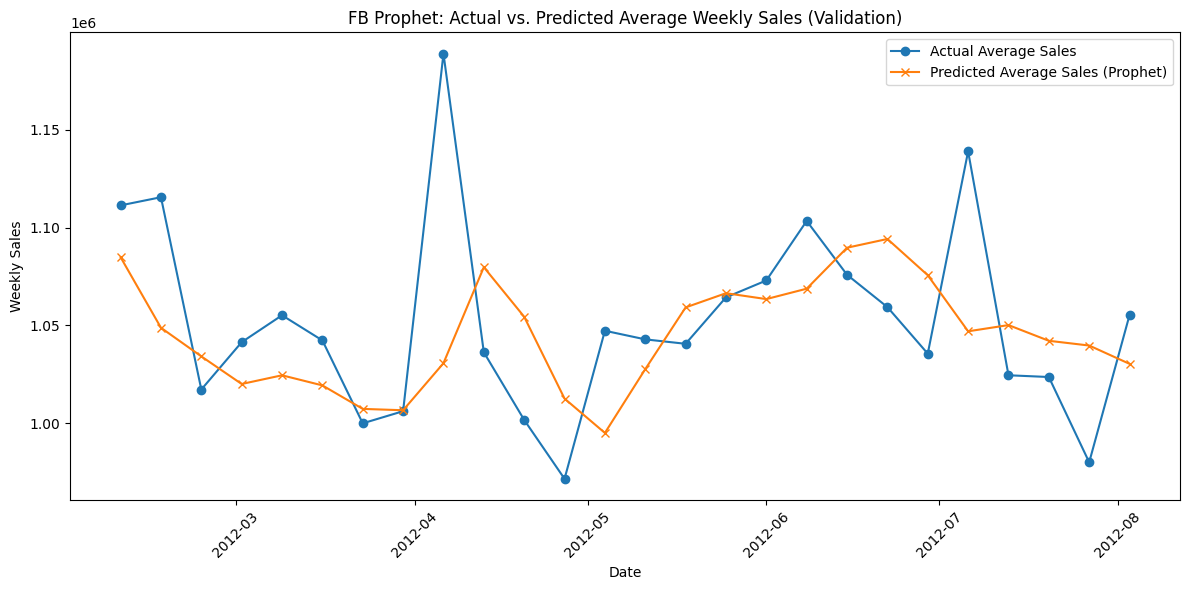

In [178]:
# Aggregate predicted and actual values by forecast date across all stores.
pred_by_date = defaultdict(list)
actual_by_date = defaultdict(list)

for store in stores:
    store_result = results_dict["Prophet"]["store_results"][store]
    for dt, pred, act in zip(store_result["forecast_dates"], 
                             store_result["predictions"], 
                             store_result["actuals"]):
        # Make sure that the forecast date is a pd.Timestamp.
        dt = pd.to_datetime(dt)
        pred_by_date[dt].append(pred)
        actual_by_date[dt].append(act)

# Sort forecast dates.
sorted_dates = sorted(pred_by_date.keys())

# Compute the average prediction and actual sales for each date.
avg_pred = [np.mean(pred_by_date[dt]) for dt in sorted_dates]
avg_actual = [np.mean(actual_by_date[dt]) for dt in sorted_dates]

plt.figure(figsize=(12, 6))
plt.plot(sorted_dates, avg_actual, marker="o", label="Actual Average Sales")
plt.plot(sorted_dates, avg_pred, marker="x", label="Predicted Average Sales (Prophet)")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.title("FB Prophet: Actual vs. Predicted Average Weekly Sales (Validation)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()